In [18]:
from lime import lime_tabular
import pickle
import pandas as pd
import pandas_profiling
from gc import collect
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from sklearn.preprocessing import normalize
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import hdbscan
from graphviz import Source
from IPython.display import SVG
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_selection import RFE

In [19]:
%matplotlib inline

In [20]:
df = pd.read_csv('bases_full.csv')

In [21]:
df = df[[
    'cod_ide', 
    'Cargo',
    'Edad',
    'Genero', 
    'EstadoCivil',
    'nProductividad',
    'nProbMoraNoHeredada', 
    'nProbMoraHeredada',
    'ingresoef', 
    'pregunta_1', 
    'pregunta_2', 
    'pregunta_3',
    'pregunta_4', 
    'pregunta_5', 
    'pregunta_6', 
    'pregunta_7', 
    'pregunta_8',
    'pregunta_9', 
    'pregunta_10', 
    'pregunta_11', 
    'pregunta_12',
    'pregunta_13', 
    'pregunta_14', 
    'pregunta_15', 
    'pregunta_16',
    'pregunta_17', 
    'pregunta_18', 
    'pregunta_19', 
    'pregunta_20',
    'pregunta_21', 
    'pregunta_22', 
    'pregunta_23', 
    'pregunta_24',
    'pregunta_25', 
    'pregunta_26', 
    'pregunta_27', 
    'pregunta_28',
    'pregunta_29', 
    'pregunta_30'
]]

In [22]:
pandas_profiling.ProfileReport(df)

In [23]:
dtypes = ['category', 'bool', 'object']
df_categorical = df.loc[:, [col for col in df.columns]].select_dtypes(include=dtypes)
df_categorical.head()
df_categorical.shape
list(df_categorical)

cod_ide                         Cargo     Genero EstadoCivil  \
0  C00000001  ASESOR COMERCIAL FUNCIONARIO  Masculino     Soltero   
1  C00000002       ASESOR COMERCIAL MASTER   Femenino       Otros   
2  C00000003       ASESOR COMERCIAL MASTER   Femenino      Casado   
3  C00000004  ASESOR COMERCIAL FUNCIONARIO   Femenino     Soltero   
4  C00000005  ASESOR COMERCIAL FUNCIONARIO   Femenino     Soltero   

  nProbMoraNoHeredada nProbMoraHeredada ingresoef  
0               bueno              malo        NO  
1                malo              malo        NO  
2                malo             bueno        NO  
3               bueno              malo        NO  
4                malo             bueno        NO

(768, 7)

['cod_ide',
 'Cargo',
 'Genero',
 'EstadoCivil',
 'nProbMoraNoHeredada',
 'nProbMoraHeredada',
 'ingresoef']

In [24]:
df = pd.get_dummies(df, columns=['Cargo', 'Genero', 'EstadoCivil'], prefix='D_')

for feature in ['nProbMoraNoHeredada', 'nProbMoraHeredada']:
    df.loc[:, feature] = df.loc[:, feature].map({ 'bueno': 1, 'malo': 0 })
    
df.loc[:, 'ingresoef'] = df.loc[:, 'ingresoef'].map({ 'SI': 1, 'NO': 0 })

df_categorical = df.loc[:, [col for col in list(df) if 
                            col in list(df_categorical) or 
                            col.startswith('D_') or
                            col.startswith('pregunta')]]

for feature in list(df_categorical):
    if feature != 'cod_ide' and not feature.startswith('pregunta'):
        df[feature].value_counts()

0    417
1    351
Name: nProbMoraNoHeredada, dtype: int64

1    402
0    366
Name: nProbMoraHeredada, dtype: int64

0    584
1    184
Name: ingresoef, dtype: int64

0    707
1     61
Name: D__ASESOR COMERCIAL FUNCIONARIO, dtype: int64

0    611
1    157
Name: D__ASESOR COMERCIAL JUNIOR 1, dtype: int64

0    528
1    240
Name: D__ASESOR COMERCIAL JUNIOR 2, dtype: int64

0    637
1    131
Name: D__ASESOR COMERCIAL MASTER, dtype: int64

0    589
1    179
Name: D__ASESOR COMERCIAL SENIOR, dtype: int64

0    530
1    238
Name: D__Femenino, dtype: int64

1    530
0    238
Name: D__Masculino, dtype: int64

0    621
1    147
Name: D__Casado, dtype: int64

0    676
1     92
Name: D__Otros, dtype: int64

1    529
0    239
Name: D__Soltero, dtype: int64

In [25]:
dtypes = ['number']
df_numeric = df.loc[:, [col for col in df.columns if col not in df_categorical.columns]].select_dtypes(include=dtypes)
df_numeric.head()
df_numeric.shape
list(df_numeric)

Edad  nProductividad
0    36        0.823077
1    46        0.750000
2    58        0.827303
3    34        1.100000
4    36        0.906250

(768, 2)

['Edad', 'nProductividad']

In [26]:
df_discrete = df.loc[:, [col for col in df_numeric.columns if (df[col].dropna() - df[col].dropna().astype(int) == 0).all()]]
df_discrete.head()
df_discrete.shape
list(df_discrete)

Edad
0    36
1    46
2    58
3    34
4    36

(768, 1)

['Edad']

In [27]:
df_continuous = df.loc[:, [col for col in df_numeric.columns if col not in df_discrete]]
df_continuous.head()
df_continuous.shape
list(df_continuous)

nProductividad
0        0.823077
1        0.750000
2        0.827303
3        1.100000
4        0.906250

(768, 1)

['nProductividad']

## Correlations

In [28]:
def make_correlation_graphic(df, title):
    corr = df.corr()
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 15))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    ax.set_title(title)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

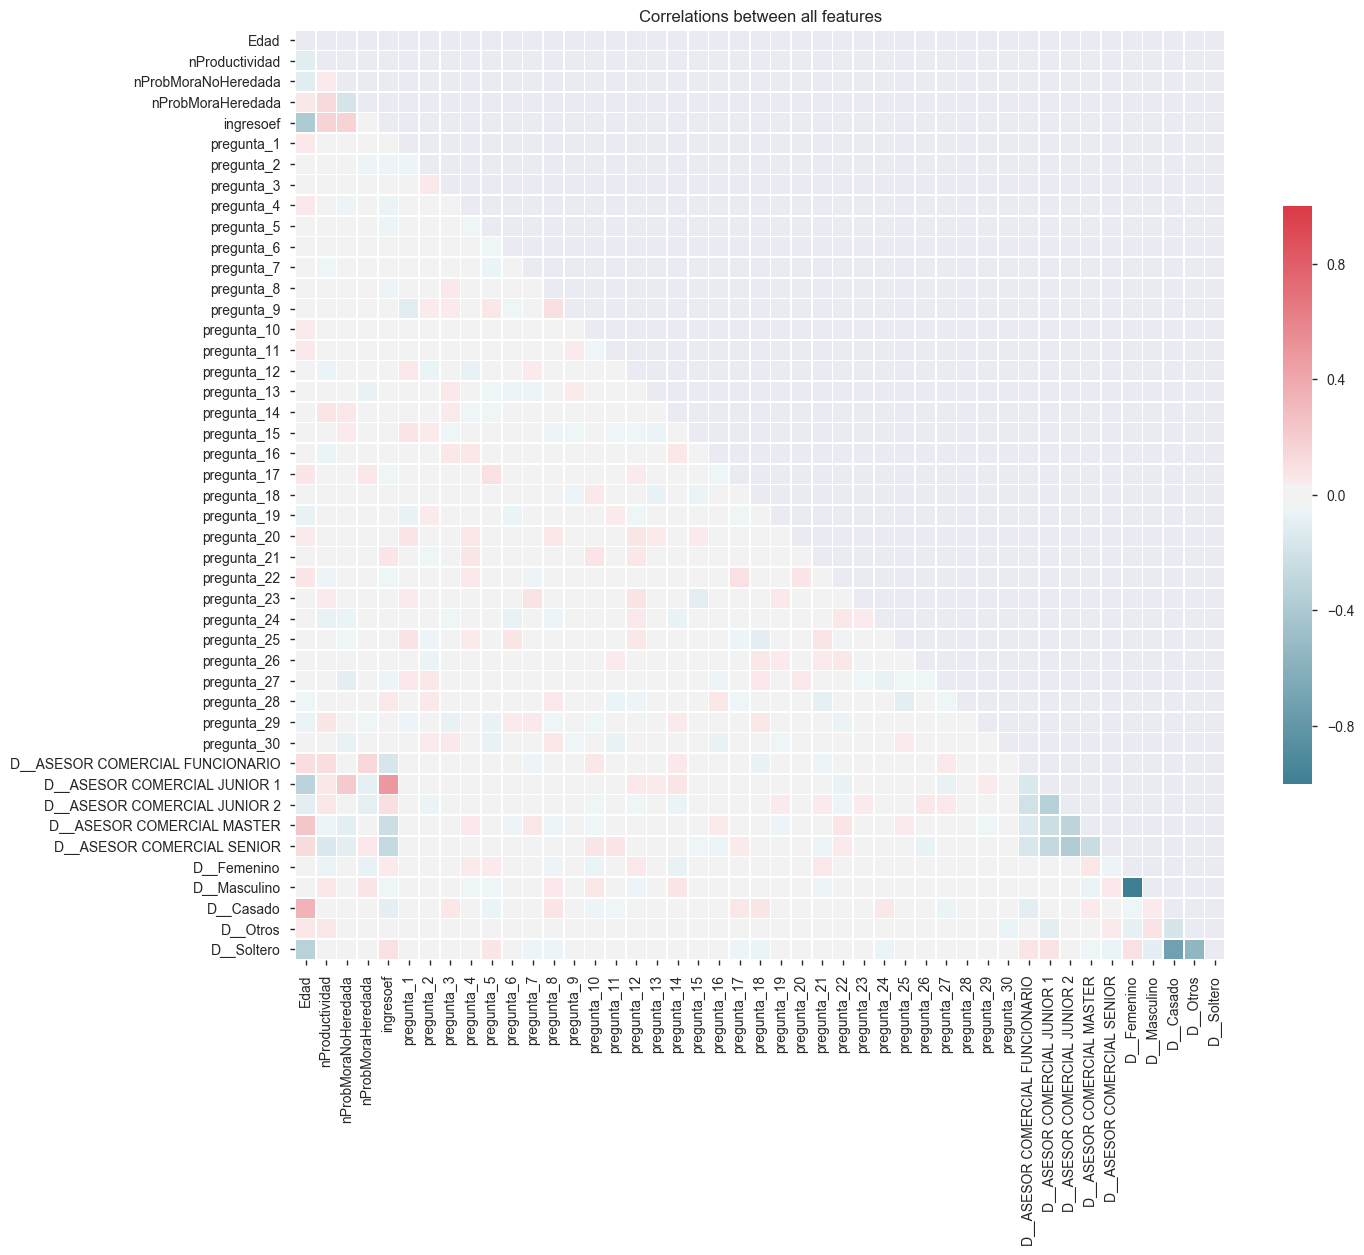

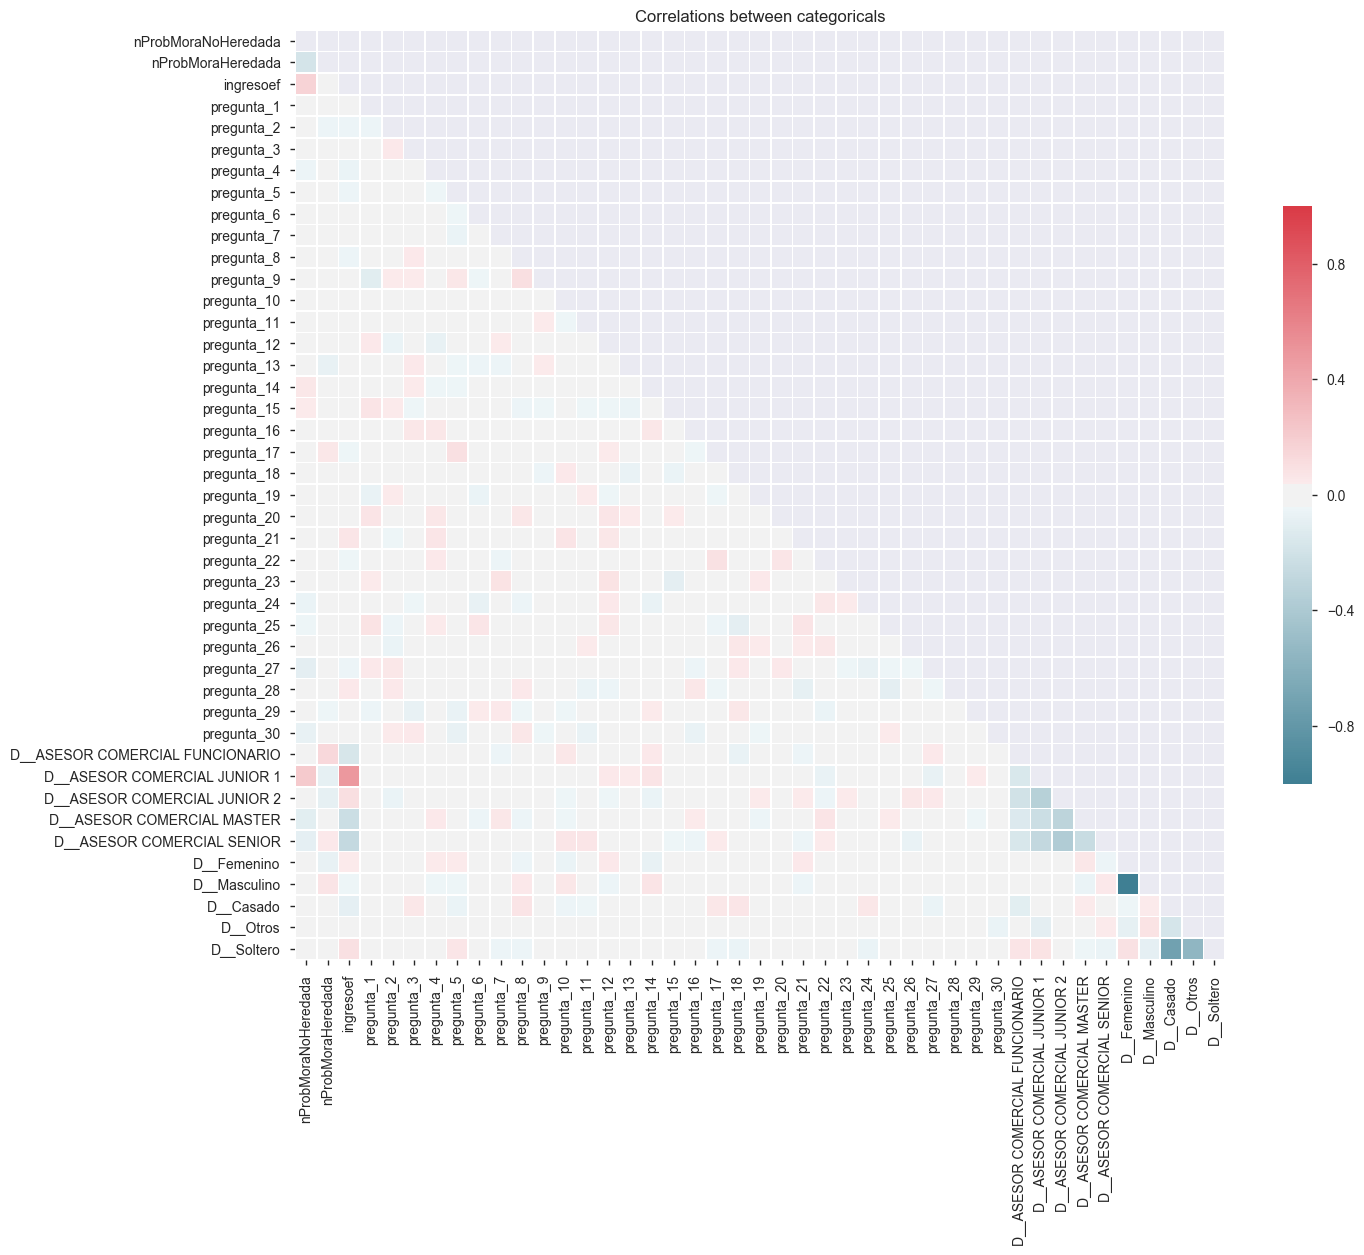

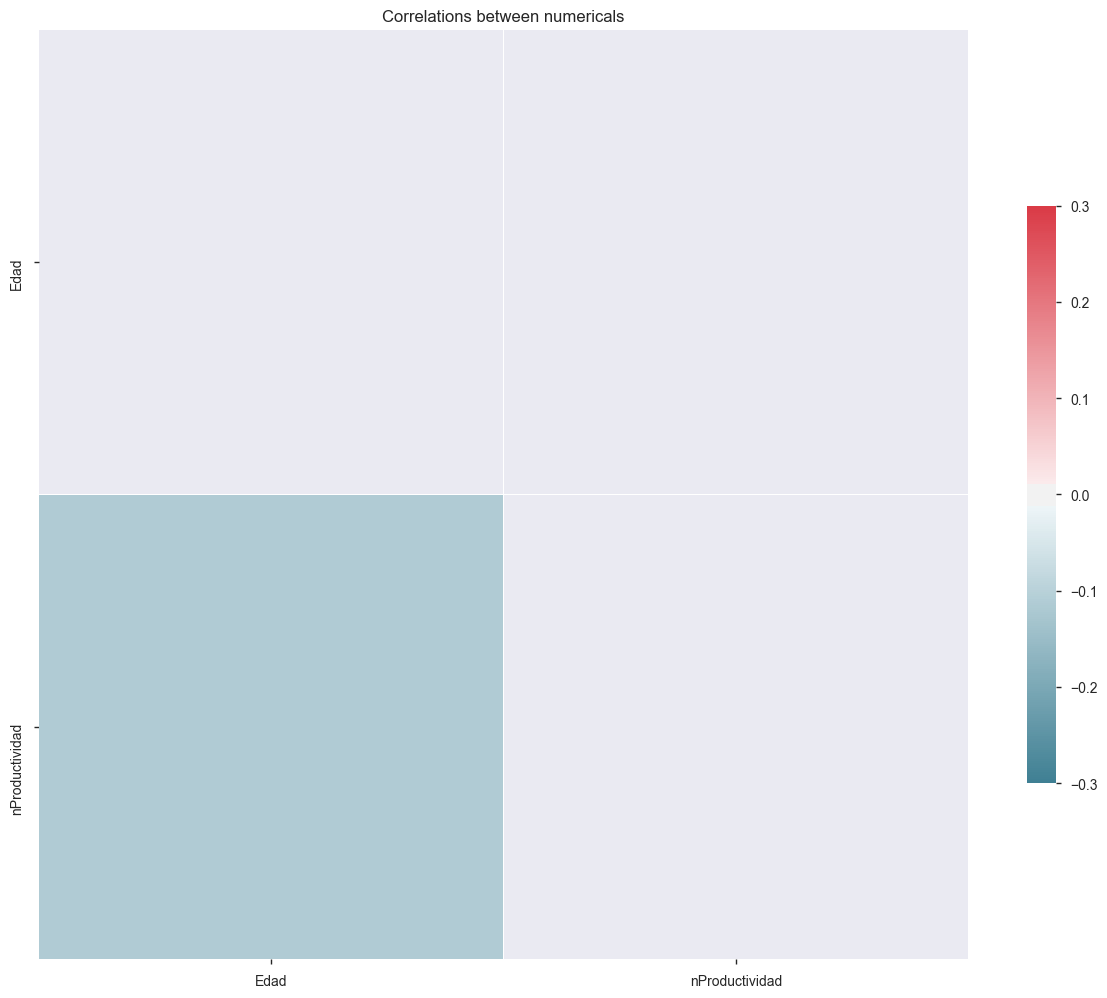

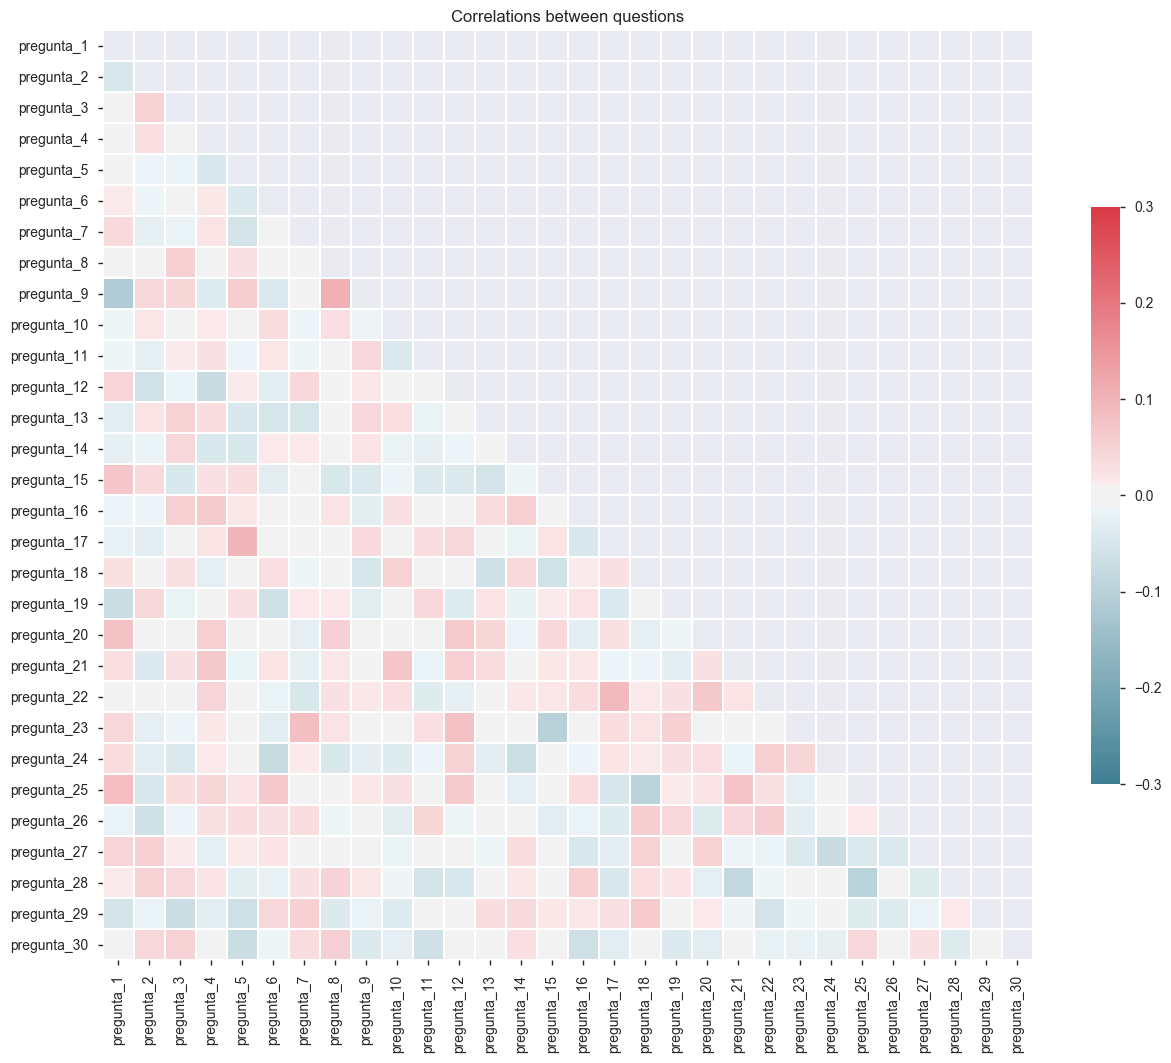

In [29]:
make_correlation_graphic(df, 'Correlations between all features')
make_correlation_graphic(df_categorical, 'Correlations between categoricals')
make_correlation_graphic(df_numeric, 'Correlations between numericals')

df_questions = df_categorical.loc[:, [col for col in df_categorical.columns if col.startswith('pregunta')]]
make_correlation_graphic(df_questions, 'Correlations between questions')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


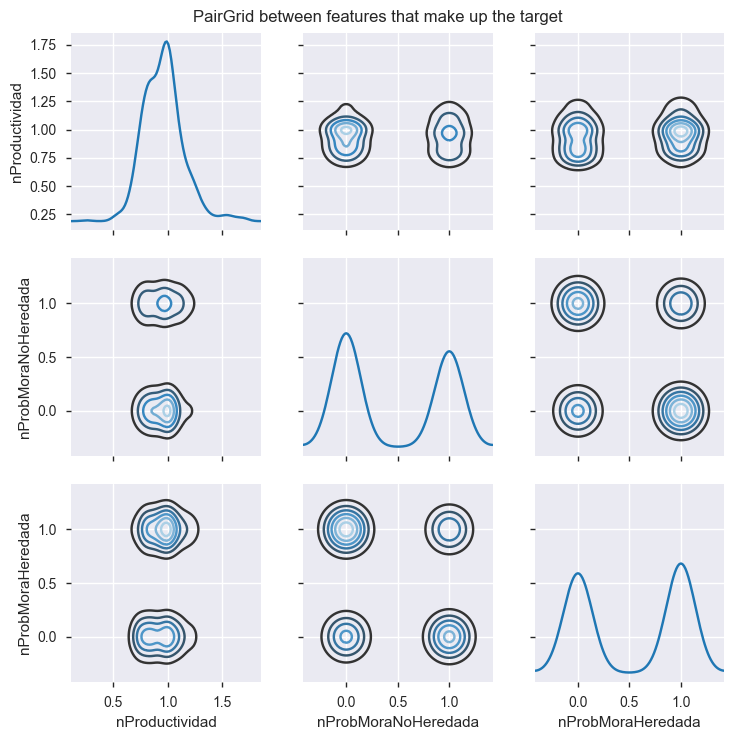

In [30]:
g = sns.PairGrid(df[['nProductividad', 'nProbMoraNoHeredada', 'nProbMoraHeredada']])
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6)
plt.subplots_adjust(top=0.95)
g.fig.suptitle('PairGrid between features that make up the target')

In [31]:
df['PM'] = df['nProbMoraHeredada'] + df['nProbMoraNoHeredada']

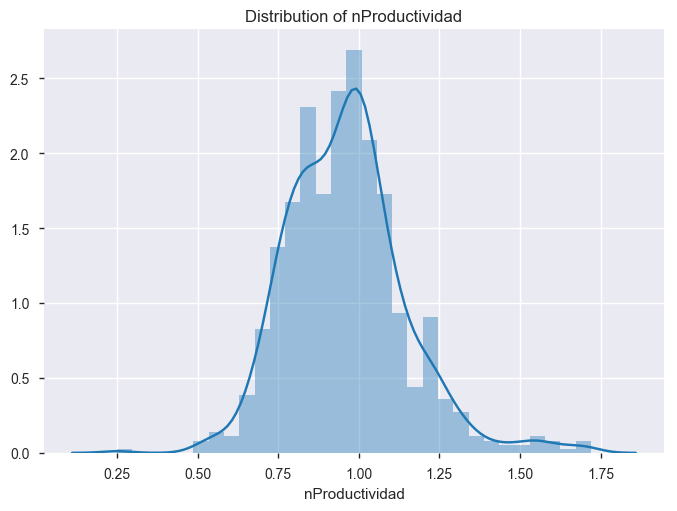

In [32]:
g = sns.distplot(df['nProductividad'])
g.set_title('Distribution of nProductividad')

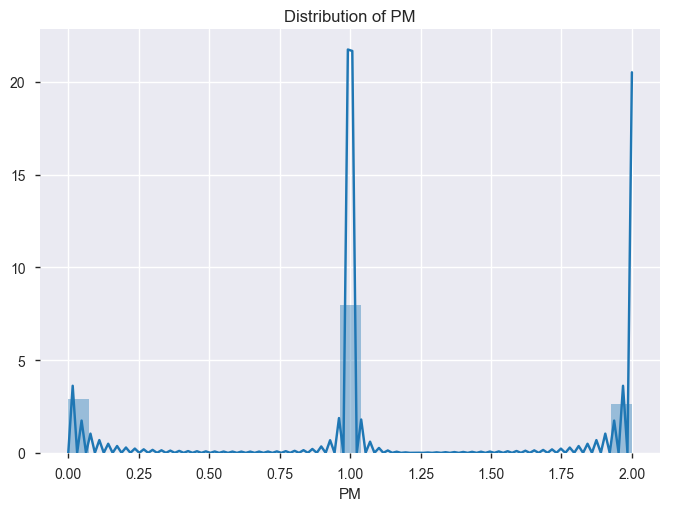

In [33]:
g = sns.distplot(df['PM'])
g.set_title('Distribution of PM')

### Creating target

In [34]:
df['PM'].value_counts()

1    455
0    164
2    149
Name: PM, dtype: int64

In [35]:
def convert_score(el):
    return 1/(el + 1)

In [36]:
df.loc[:, 'PM'] = df.loc[:, 'PM'].apply(convert_score)

In [37]:
df['PM'].value_counts()

0.500000    455
1.000000    164
0.333333    149
Name: PM, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


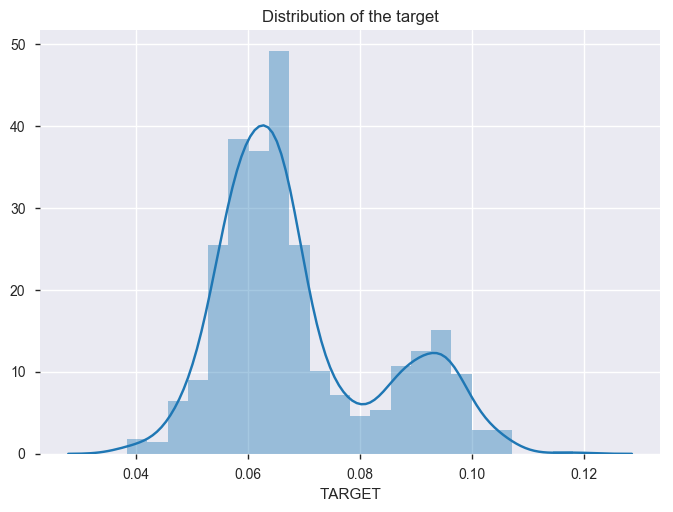

In [38]:
df['N_nProductividad'] = normalize(df['nProductividad'])[0]
df['N_PM'] = normalize(df['PM'])[0]
df['TARGET'] = df['N_nProductividad'] + df['N_PM']
g = sns.distplot(df['TARGET'])
g.set_title('Distribution of the target')

In [39]:
df = df.drop(['PM', 'N_nProductividad', 'N_PM', 'nProductividad', 'nProbMoraHeredada', 'nProbMoraNoHeredada'], axis=1)

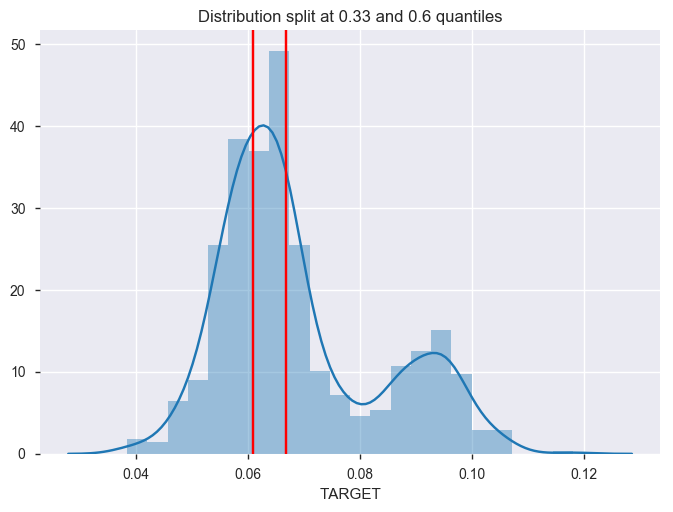

In [40]:
margin1 = 0.33
margin2 = 0.60

g = sns.distplot(df['TARGET'])
g.set_title('Distribution split at {} and {} quantiles'.format(margin1, margin2))
sns.plt.axvline(df['TARGET'].quantile(margin1), color='r')
sns.plt.axvline(df['TARGET'].quantile(margin2), color='r')

plt.show()

In [41]:
df[['cod_ide', 'TARGET']].head()

cod_ide    TARGET
0  C00000001  0.059532
1  C00000002  0.085980
2  C00000003  0.059688
3  C00000004  0.069756
4  C00000005  0.062603

In [42]:
categories = ['bad', 'normal', 'good']
cuts = [min(df['TARGET']), df['TARGET'].quantile(margin1), df['TARGET'].quantile(margin2), max(df['TARGET'])]
df['TARGET'] = pd.cut(df['TARGET'], cuts, labels=categories, include_lowest=True)

In [43]:
df[['cod_ide', 'TARGET']].head()

cod_ide  TARGET
0  C00000001     bad
1  C00000002    good
2  C00000003     bad
3  C00000004    good
4  C00000005  normal

In [44]:
df.loc[:, 'TARGET'] = df.loc[:, 'TARGET'].map({
    'bad': 0,
    'normal': 1,
    'good': 2
})
df['TARGET'].value_counts()

2    307
0    258
1    203
Name: TARGET, dtype: int64

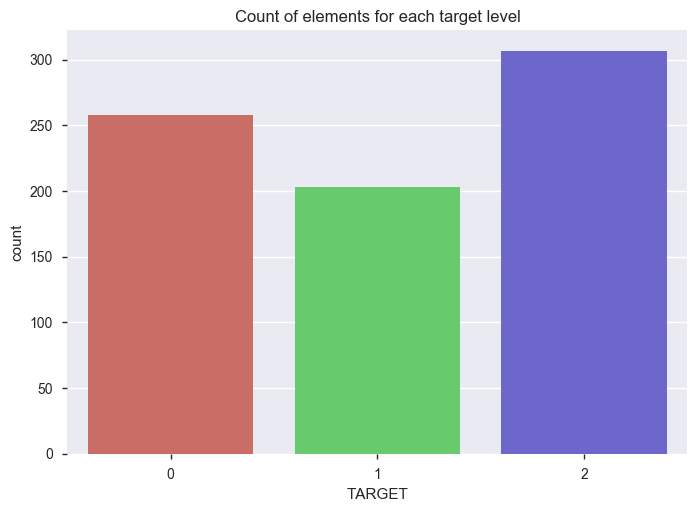

In [45]:
g = sns.countplot(x="TARGET", data=df, palette='hls')
g.set_title('Count of elements for each target level')

In [46]:
df = df.drop(['cod_ide'], axis=1)

In [47]:
y = df['TARGET']
X = df.drop('TARGET', axis=1)

In [48]:
X.shape, y.shape

((768, 42), (768,))

# Clustering

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

Edad  ingresoef  pregunta_1  pregunta_2  pregunta_3  pregunta_4  \
0    36          0    0.210433    0.014503    0.580707    0.475461   
1    46          0    0.789044    0.343001    0.058207    0.926026   
2    58          0    0.242838    0.528969    0.716495    0.489488   
3    34          0    0.761830    0.494812    0.321391    0.524197   
4    36          0    0.945418    0.833204    0.601921    0.857995   

   pregunta_5  pregunta_6  pregunta_7  pregunta_8   ...     \
0    0.191990    0.208157    0.007626    0.853459   ...      
1    0.871500    0.939968    0.929000    0.118791   ...      
2    0.286807    0.528751    0.501223    0.036598   ...      
3    0.645303    0.035893    0.909352    0.005753   ...      
4    0.926111    0.913815    0.609726    0.990892   ...      

   D__ASESOR COMERCIAL JUNIOR 1  D__ASESOR COMERCIAL JUNIOR 2  \
0                             0                             0   
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   D__ASESOR COMERCIAL MASTER  D__ASESOR COMERCIAL SENIOR  D__Femenino  \
0                           0                           0            0   
1                           1                           0            1   
2                           1                           0            1   
3                           0                           0            1   
4                           0                           0            1   

   D__Masculino  D__Casado  D__Otros  D__Soltero  cluster  
0             1          0         0           1        1  
1             0          0         1           0       -1  
2             0          1         0           0       -1  
3             0          0         0           1        1  
4             0          0         0           1        1  

[5 rows x 43 columns]

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

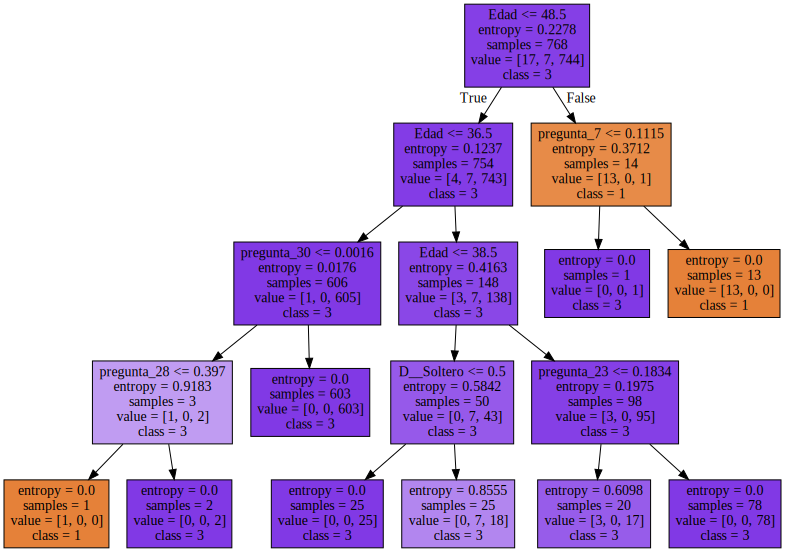

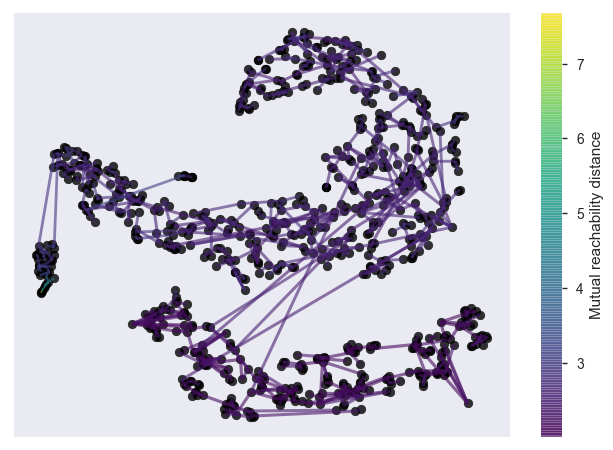

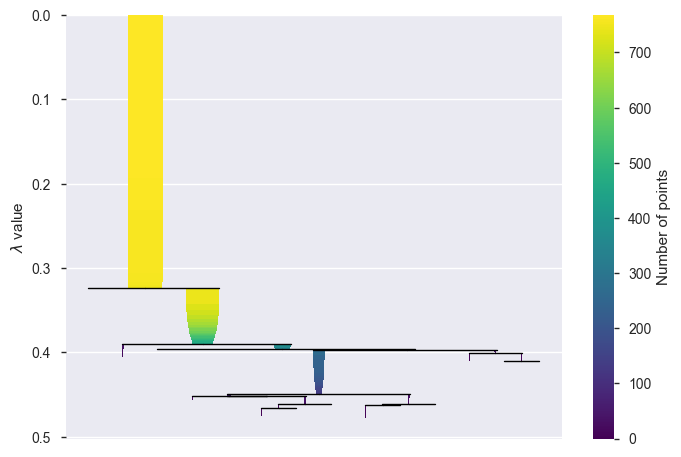

In [52]:
clusterer = hdbscan.HDBSCAN(gen_min_span_tree=True)
clusterer.fit(X)
plt.figure()
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      edge_linewidth=1)
plt.figure()
clusterer.condensed_tree_.plot(selection_palette=sns.color_palette())



palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
X['cluster'] = pd.Series(clusterer.labels_)
X.head()
y_cluster = X['cluster']
X_cluster = X.drop('cluster', axis=1)

cluster_names = list(range(1, len(X['cluster'].value_counts()) + 1))

dtc = DecisionTreeClassifier(random_state=777, max_depth=4, criterion='entropy')
dtc.fit(X_cluster, y_cluster)

graph = Source(export_graphviz(dtc, out_file=None, feature_names=X_cluster.columns, filled=True, class_names=list(map(str, cluster_names))))

SVG(graph.pipe(format='svg'))

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Edad  ingresoef  pregunta_1  pregunta_2  pregunta_3  pregunta_4  \
1     46          0    0.789044    0.343001    0.058207    0.926026   
3     34          0    0.761830    0.494812    0.321391    0.524197   
6     35          0    0.221027    0.442683    0.042709    0.845306   
12    44          0    0.975351    0.448876    0.645230    0.514550   
13    46          0    0.182366    0.394757    0.738945    0.458081   

    pregunta_5  pregunta_6  pregunta_7  pregunta_8   ...    \
1     0.871500    0.939968    0.929000    0.118791   ...     
3     0.645303    0.035893    0.909352    0.005753   ...     
6     0.073125    0.387089    0.836789    0.340532   ...     
12    0.501630    0.906539    0.949537    0.250857   ...     
13    0.429477    0.107369    0.068157    0.299596   ...     

    D__ASESOR COMERCIAL JUNIOR 1  D__ASESOR COMERCIAL JUNIOR 2  \
1                              0                             0   
3                              0                             0   
6                              0                             0   
12                             0                             0   
13                             0                             0   

    D__ASESOR COMERCIAL MASTER  D__ASESOR COMERCIAL SENIOR  D__Femenino  \
1                            1                           0            1   
3                            0                           0            1   
6                            0                           0            1   
12                           1                           0            1   
13                           1                           0            1   

    D__Masculino  D__Casado  D__Otros  D__Soltero  TARGET  
1              0          0         1           0       2  
3              0          0         0           1       2  
6              0          1         0           0       2  
12             0          1         0           0       2  
13             0          0         0           1       2  

[5 rows x 43 columns]

1     1.0
3    -1.0
6    -1.0
12   -1.0
13   -1.0
Name: cluster, dtype: float64

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

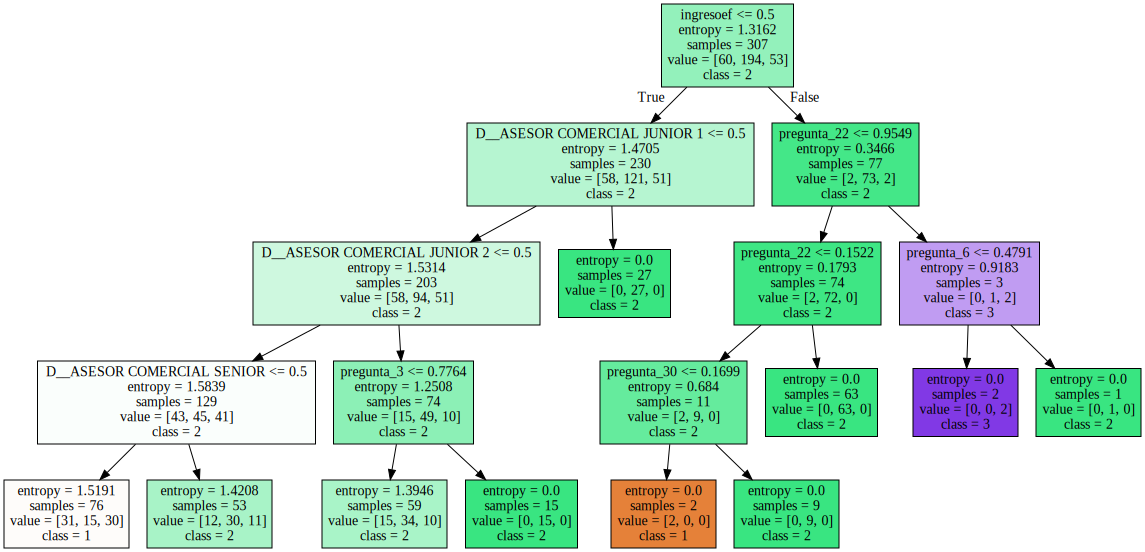

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Edad  ingresoef  pregunta_1  pregunta_2  pregunta_3  pregunta_4  \
0     36          0    0.210433    0.014503    0.580707    0.475461   
2     58          0    0.242838    0.528969    0.716495    0.489488   
8     41          0    0.113082    0.217811    0.570358    0.059313   
9     42          0    0.872726    0.196752    0.718091    0.307564   
11    33          0    0.462763    0.730985    0.565522    0.622575   

    pregunta_5  pregunta_6  pregunta_7  pregunta_8   ...    \
0     0.191990    0.208157    0.007626    0.853459   ...     
2     0.286807    0.528751    0.501223    0.036598   ...     
8     0.794239    0.425821    0.976964    0.074504   ...     
9     0.941359    0.259736    0.217433    0.567548   ...     
11    0.603140    0.679366    0.042535    0.176089   ...     

    D__ASESOR COMERCIAL JUNIOR 1  D__ASESOR COMERCIAL JUNIOR 2  \
0                              0                             0   
2                              0                             0   
8                              0                             1   
9                              0                             0   
11                             0                             0   

    D__ASESOR COMERCIAL MASTER  D__ASESOR COMERCIAL SENIOR  D__Femenino  \
0                            0                           0            0   
2                            1                           0            1   
8                            0                           0            0   
9                            0                           1            0   
11                           1                           0            1   

    D__Masculino  D__Casado  D__Otros  D__Soltero  TARGET  
0              1          0         0           1       0  
2              0          1         0           0       0  
8              1          0         1           0       0  
9              1          0         0           1       0  
11             0          1         0           0       0  

[5 rows x 43 columns]

0     0.0
2     0.0
8     0.0
9     0.0
11    0.0
Name: cluster, dtype: float64

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

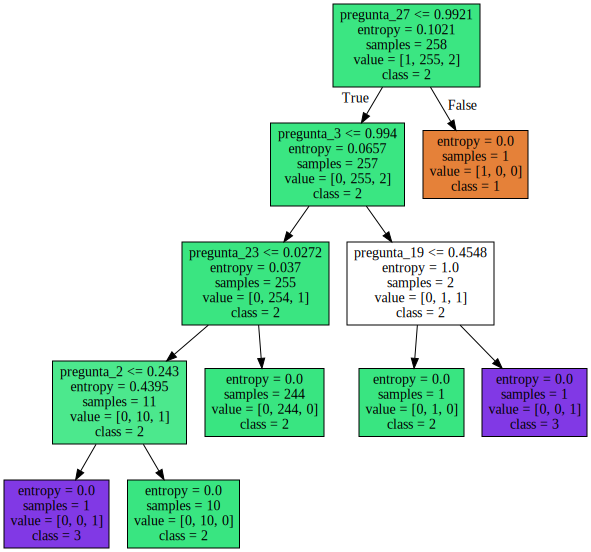

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Edad  ingresoef  pregunta_1  pregunta_2  pregunta_3  pregunta_4  \
4     36          0    0.945418    0.833204    0.601921    0.857995   
5     43          0    0.469796    0.874347    0.613986    0.975214   
7     41          0    0.137555    0.787741    0.155432    0.278163   
10    49          0    0.832347    0.064413    0.386503    0.915506   
15    32          0    0.222938    0.129518    0.155241    0.203387   

    pregunta_5  pregunta_6  pregunta_7  pregunta_8   ...    \
4     0.926111    0.913815    0.609726    0.990892   ...     
5     0.434296    0.976213    0.565399    0.018880   ...     
7     0.120059    0.672811    0.560806    0.962164   ...     
10    0.585383    0.706981    0.259823    0.475864   ...     
15    0.391220    0.027578    0.392845    0.588458   ...     

    D__ASESOR COMERCIAL JUNIOR 1  D__ASESOR COMERCIAL JUNIOR 2  \
4                              0                             0   
5                              0                             0   
7                              0                             0   
10                             1                             0   
15                             0                             0   

    D__ASESOR COMERCIAL MASTER  D__ASESOR COMERCIAL SENIOR  D__Femenino  \
4                            0                           0            1   
5                            1                           0            1   
7                            0                           0            0   
10                           0                           0            1   
15                           0                           1            0   

    D__Masculino  D__Casado  D__Otros  D__Soltero  TARGET  
4              0          0         0           1       1  
5              0          0         0           1       1  
7              1          0         0           1       1  
10             0          0         0           1       1  
15             1          0         0           1       1  

[5 rows x 43 columns]

4     1.0
5     1.0
7     1.0
10    1.0
15    1.0
Name: cluster, dtype: float64

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

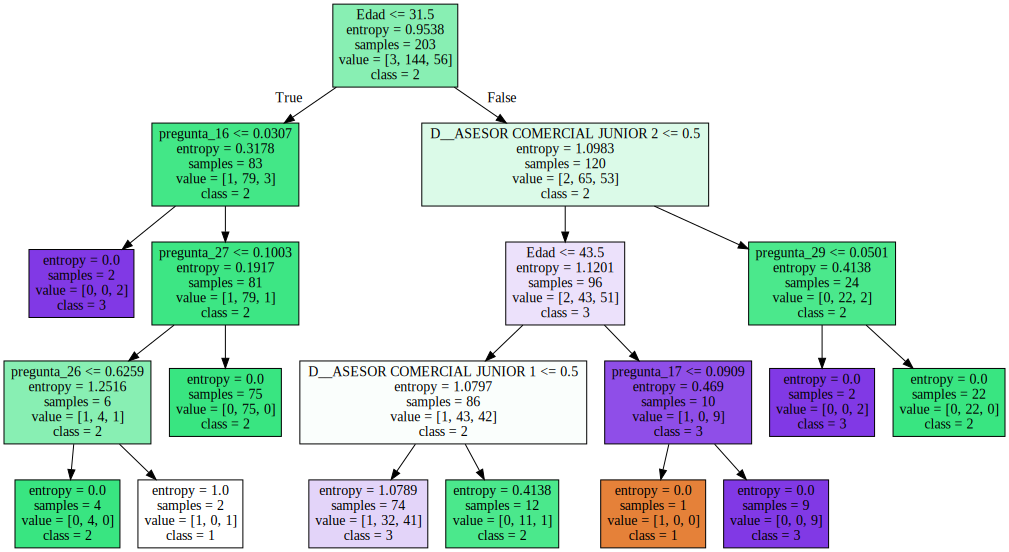

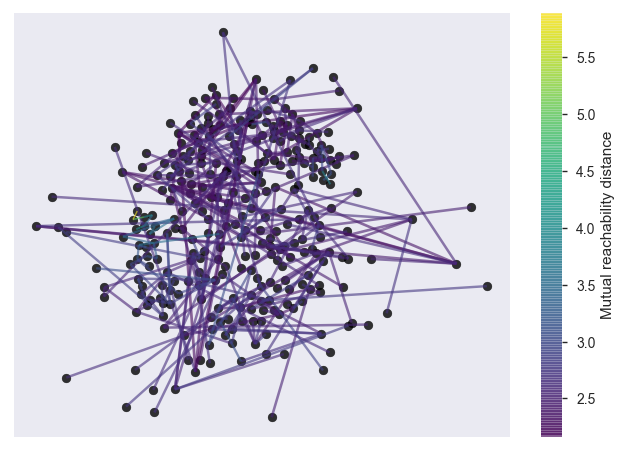

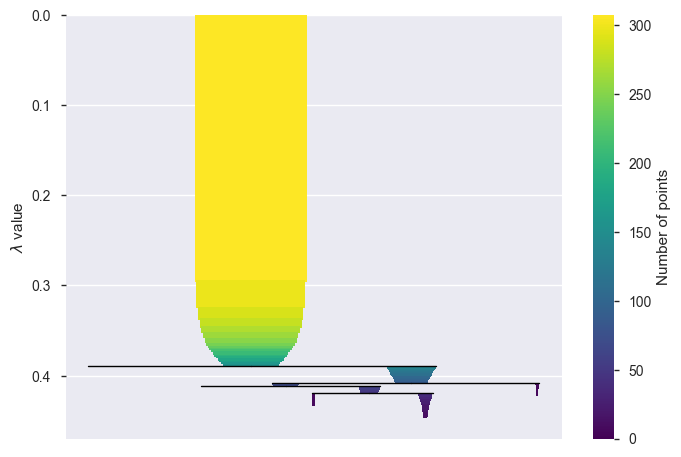

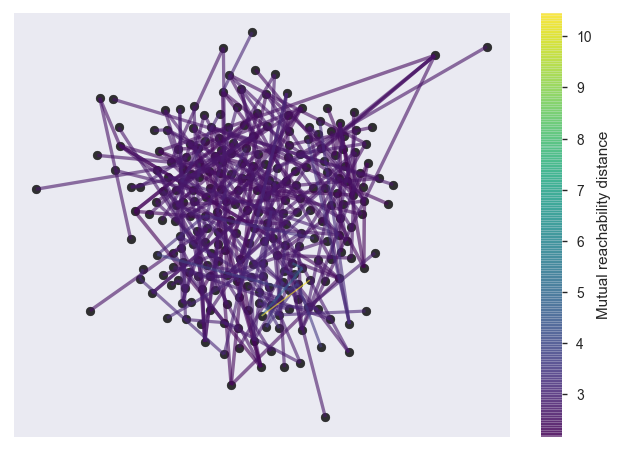

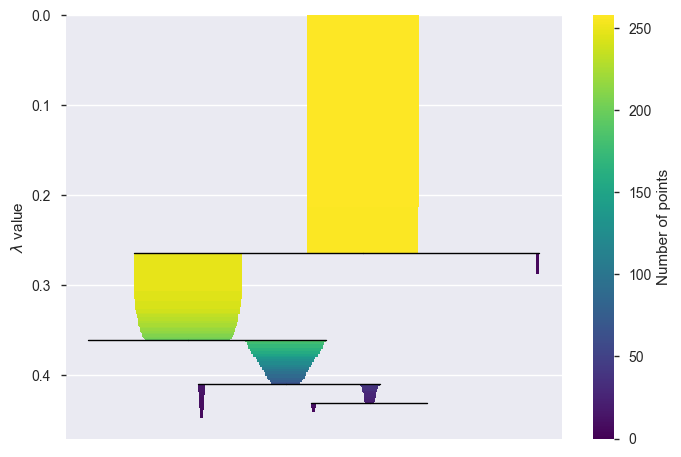

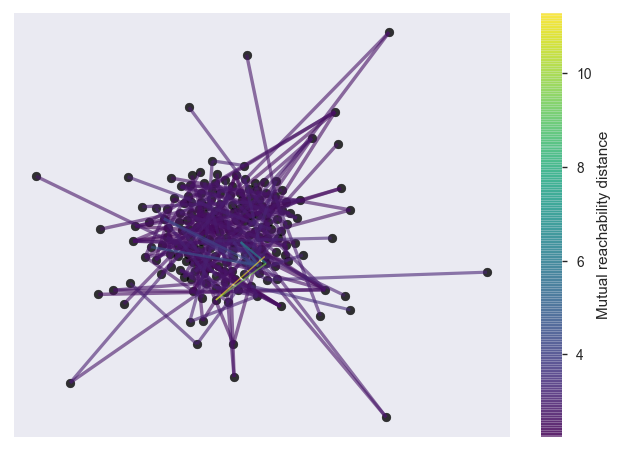

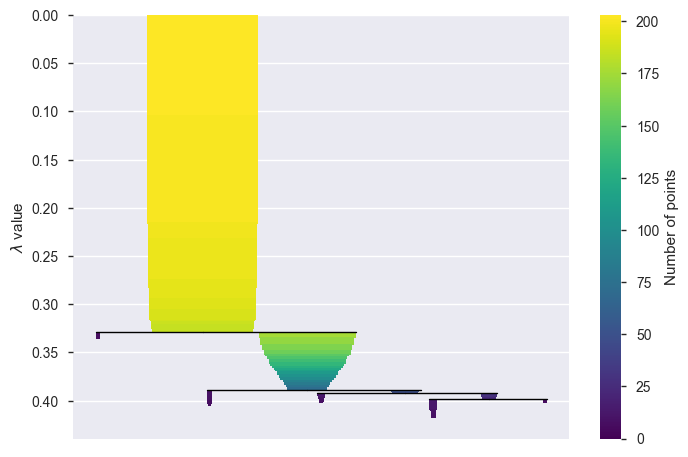

In [53]:
for target_class in list(y.value_counts().index):
    X_target = df.loc[df['TARGET'] == target_class]
    clusterer = hdbscan.HDBSCAN(gen_min_span_tree=True)
    clusterer.fit(X_target)
    plt.figure()
    clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                          edge_alpha=0.6,
                                          edge_linewidth=1)
    plt.figure()
    clusterer.condensed_tree_.plot(selection_palette=sns.color_palette())
    palette = sns.color_palette()
    cluster_colors = [sns.desaturate(palette[col], sat)
                      if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                      zip(clusterer.labels_, clusterer.probabilities_)]
    X_target['cluster'] = pd.Series(clusterer.labels_)
    y_cluster = X_target['cluster']
    X_cluster = X_target.drop('cluster', axis=1)
    
    X_cluster.head()
    y_cluster.head()
    
    cluster_names = list(range(1, len(X_target['cluster'].value_counts()) + 1))

    dtc = DecisionTreeClassifier(random_state=777, max_depth=4, criterion='entropy')
    dtc.fit(X_cluster.fillna(0), y_cluster.fillna(0))

    graph = Source(export_graphviz(dtc, out_file=None, feature_names=X_cluster.columns, filled=True, class_names=list(map(str, cluster_names))))

    SVG(graph.pipe(format='svg'))

In [54]:
list(y.value_counts().index)

[2, 0, 1]

In [55]:
X.shape, y.shape

((768, 43), (768,))

In [56]:
X.to_csv('hk1_X.csv', index=False)
y.to_csv('hk1_y.csv', index=False)

# Cross-validation

In [57]:
eval_size = 0.1
kf = StratifiedKFold(df['TARGET'], round(1./eval_size))
train_ix, valid_ix = next(iter(kf))

In [58]:
X_train, y_train = X.iloc[train_ix], y.iloc[train_ix]
X_valid, y_valid = X.iloc[valid_ix], y.iloc[valid_ix]
X_train.shape, y_train.shape
X_valid.shape, y_valid.shape

((690, 43), (690,))

((78, 43), (78,))

In [59]:
def increase_value(feature, temp, value):

    before_value = temp.loc[feature]
    after_value = temp.loc[feature] + value

    before = model.predict(temp)[0]
    temp.loc[feature] += value
    after = model.predict(temp)[0]
    
    if sum(before == after) == 0:  
        print('\nIncreasing {}'.format(feature))
        print('From {} to {}'.format(before_value, after_value))
        print('Before: {} (class {})'.format(before, list(before).index(max(before))))
        print(' After: {} (class {})'.format(after, list(after).index(max(after))))

In [60]:
def decrease_value(feature, temp, value):

    before_value = temp.loc[feature]
    after_value = temp.loc[feature] - value

    before = model.predict(temp)[0]
    temp.loc[feature] -= value
    after = model.predict(temp)[0]
    
    if sum(before == after) == 0:  
        print('\nDecreasing {}'.format(feature))
        print('From {} to {}'.format(before_value, after_value))
        print('Before: {} (class {})'.format(before, list(before).index(max(before))))
        print(' After: {} (class {})'.format(after, list(after).index(max(after))))

# Models

In [61]:
model_results = {
    'lightgbm': {
        'recall': None,
        'precision': None,
        'accuracy': None,
        'fe_entropy': [],
        'fe_rfe': []
    },
    'random_forest': {
        'recall': None,
        'precision': None,
        'accuracy': None,
        'fe_entropy': [],
        'fe_rfe': []
    },
    'extra_trees': {
        'recall': None,
        'precision': None,
        'accuracy': None,
        'fe_entropy': [],
        'fe_rfe': []
    }
}

## LightGBM

In [62]:
d_train = lgb.Dataset(X_train, y_train)
d_valid = lgb.Dataset(X_valid, y_valid, reference=d_train)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=0, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05], 'num_leaves': [8, 10, 20, 30, 40, 50], 'boosting_type': ['gbdt'], 'objective': ['multiclass'], 'metric': ['multi_logloss'], 'num_class': [3], 'seed': [777], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1], 'subsample': [0.6, 0.7, 0.8, 0.9, 1], 'reg_alpha': [0, 0.1, 0.5, 1], 'reg_lambda': [0, 0.01, 0.05, 0.1, 1, 2, 5, 6, 7, 9, 10], 'is_unbalance': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.7,
 'is_unbalance': True,
 'learning_rate': 0.03,
 'metric': 'multi_logloss',
 'num_class': 3,
 'num_leaves': 30,
 'objective': 'multiclass',
 'reg_alpha': 0.5,
 'reg_lambda': 2,
 'seed': 777,
 'subsample': 0.6}

Recall: 0.45161290322580644
Precision: 0.4
Accuracy: 0.3974358974358974


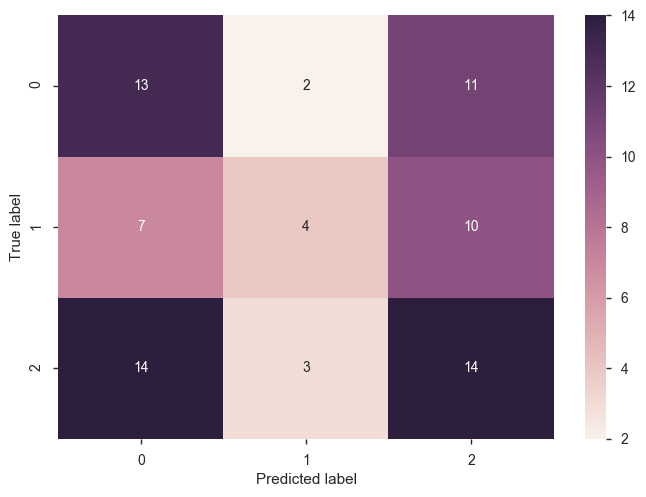

In [63]:
estimator = lgb.LGBMClassifier()
param_grid = {
    'learning_rate': [0.01, 0.02, 0.03,0.04, 0.05],
    'num_leaves': [8, 10, 20, 30, 40, 50],
    'boosting_type' : ['gbdt'],
    'objective' : ['multiclass'],
    'metric': ['multi_logloss'],
    'num_class': [3],
    'seed' : [777],
    'colsample_bytree' : [0.6, 0.7,0.8,0.9,1],
    'subsample' : [0.6, 0.7,0.8,0.9,1],
    'reg_alpha' : [0,0.1,0.5,1],
    'reg_lambda' : [0,0.01, 0.05, 0.1, 1,2,5,6,7,9,10],
    'is_unbalance' : [True,False],
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

y_pred = clf.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Precision: {}'.format(cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))

[1]	valid_0's multi_logloss: 1.09671
[2]	valid_0's multi_logloss: 1.09417
[3]	valid_0's multi_logloss: 1.09335
[4]	valid_0's multi_logloss: 1.09321
[5]	valid_0's multi_logloss: 1.09289
[6]	valid_0's multi_logloss: 1.09215
[7]	valid_0's multi_logloss: 1.09001
[8]	valid_0's multi_logloss: 1.08738
[9]	valid_0's multi_logloss: 1.08683
[10]	valid_0's multi_logloss: 1.08649
[11]	valid_0's multi_logloss: 1.08612
[12]	valid_0's multi_logloss: 1.08397
[13]	valid_0's multi_logloss: 1.08318
[14]	valid_0's multi_logloss: 1.08339
[15]	valid_0's multi_logloss: 1.08267
[16]	valid_0's multi_logloss: 1.0837
[17]	valid_0's multi_logloss: 1.08358
[18]	valid_0's multi_logloss: 1.08225
[19]	valid_0's multi_logloss: 1.08078
[20]	valid_0's multi_logloss: 1.08111
[21]	valid_0's multi_logloss: 1.07975
[22]	valid_0's multi_logloss: 1.08001
[23]	valid_0's multi_logloss: 1.08007
[24]	valid_0's multi_logloss: 1.07881
[25]	valid_0's multi_logloss: 1.07846
[26]	valid_0's multi_logloss: 1.07694
[27]	valid_0's multi_l

Recall: 0.4838709677419355
Precision: 0.4838709677419355
Accuracy: 0.41025641025641024


Feature importance based on entropy:
Feature ranking with recursive feature elimination:


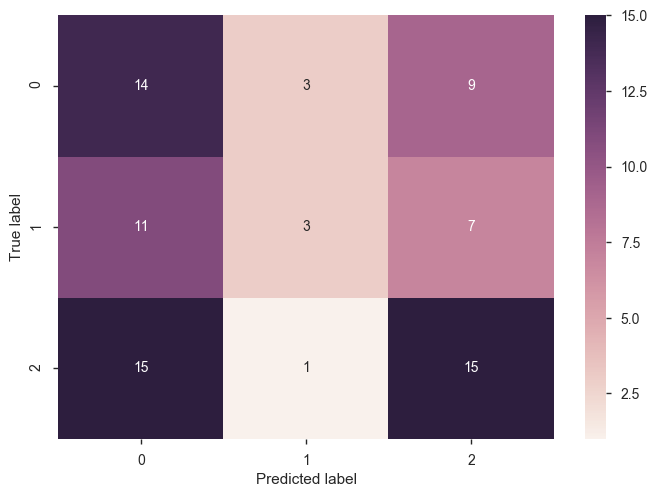

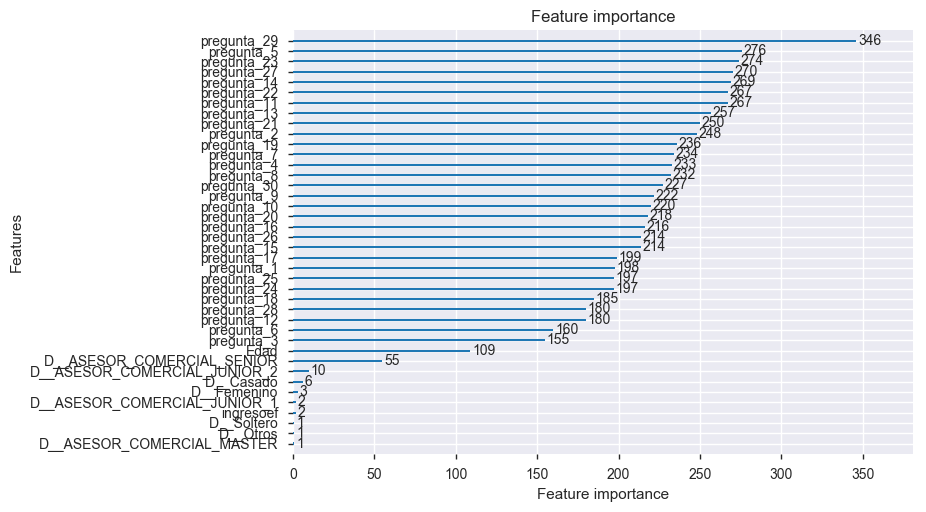

In [64]:
model = lgb.train(clf.best_params_, d_train, 100, valid_sets=d_valid)

y_pred = model.predict(X_valid)

y_pred_trunc = list()
for row in y_pred:
    y_pred_trunc.append(list(row).index(max(row)))
y_pred_trunc = pd.Series(y_pred_trunc)

cm = confusion_matrix(y_valid, y_pred_trunc)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

recall = cm[2][2]/sum(cm[2])
print('Recall: {}'.format(recall))
model_results['lightgbm']['recall'] = recall

precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
print('Precision: {}'.format(precision))
model_results['lightgbm']['precision'] = precision

accuracy = accuracy_score(y_pred_trunc, y_valid)
print('Accuracy: {}'.format(accuracy))
model_results['lightgbm']['accuracy'] = accuracy

lgb.plot_importance(model)

print('Feature importance based on entropy:')
d = dict(zip(model.feature_name(), model.feature_importance()))
fe_entropy = sorted(d.items(), key=lambda x: x[1], reverse=True)
model_results['lightgbm']['fe_entropy'] = fe_entropy

print('Feature ranking with recursive feature elimination:')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
d = dict(zip(X.columns, selector.ranking_))
fe_rfe = sorted(d.items(), key=lambda x: x[1])
model_results['lightgbm']['fe_rfe'] = fe_rfe

### LIME using LightGBM

In [65]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train, 
    feature_names=list(X_train),
    discretize_continuous=False
    )
i = np.random.randint(0, X_valid.shape[0])
exp = explainer.explain_instance(X_valid.iloc[i], model.predict)
exp.show_in_notebook(show_table=True, show_all=False)
temp = X_valid.iloc[i].copy()
for feature in X_valid.columns:
    increase_value(feature, temp, 10)
    decrease_value(feature, temp, 20)


Increasing Edad
From 38.0 to 48.0
Before: [ 0.48957178  0.17658966  0.33383856] (class 0)
 After: [ 0.54578225  0.15996628  0.29425146] (class 0)

Decreasing Edad
From 48.0 to 28.0
Before: [ 0.54578225  0.15996628  0.29425146] (class 0)
 After: [ 0.48132838  0.17204455  0.34662708] (class 0)

Increasing pregunta_1
From 0.5263108672172596 to 10.52631086721726
Before: [ 0.48132838  0.17204455  0.34662708] (class 0)
 After: [ 0.48379492  0.16702493  0.34918015] (class 0)

Decreasing pregunta_1
From 10.52631086721726 to -9.47368913278274
Before: [ 0.48379492  0.16702493  0.34918015] (class 0)
 After: [ 0.49335208  0.17198065  0.33466728] (class 0)

Increasing pregunta_2
From 0.4298467908301464 to 10.429846790830146
Before: [ 0.49335208  0.17198065  0.33466728] (class 0)
 After: [ 0.44547961  0.17676661  0.37775379] (class 0)

Decreasing pregunta_2
From 10.429846790830146 to -9.570153209169854
Before: [ 0.44547961  0.17676661  0.37775379] (class 0)
 After: [ 0.484872    0.19339064  0.32173

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:423: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


## Random Forest

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=777,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [120, 300, 500, 800, 1200], 'max_depth': [5, 8, 15, 25, 30, None], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

{'max_depth': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 1200}

Recall: 0.8064516129032258
Precision: 0.38461538461538464
Accuracy: 0.358974358974359


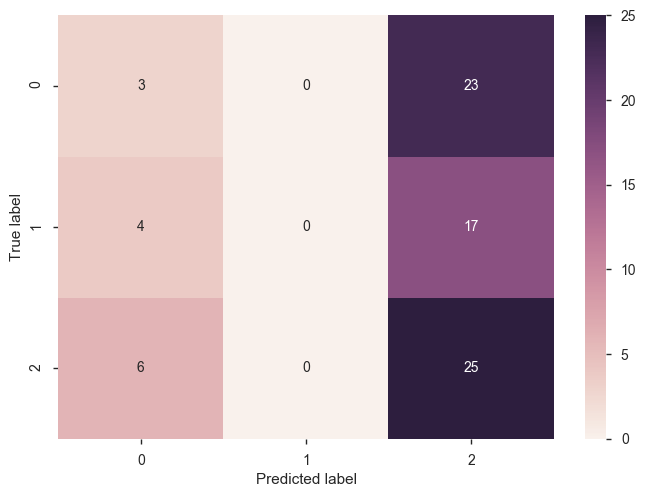

In [66]:
estimator = RandomForestClassifier(random_state=777)
param_grid = {
    'n_estimators': [120, 300, 500, 800, 1200],
    'max_depth': [5, 8, 15, 25, 30, None],
    'min_samples_split': [2, 5, 10, 15, 100],
    'min_samples_leaf': [2, 5, 10]
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

y_pred = clf.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Precision: {}'.format(cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=1200, n_jobs=1, oob_score=False, random_state=777,
            verbose=0, warm_start=False)

Recall: 0.8064516129032258
Precision: 0.38461538461538464
Accuracy: 0.358974358974359
Feature importance based on entropy:
Feature ranking with recursive feature elimination:


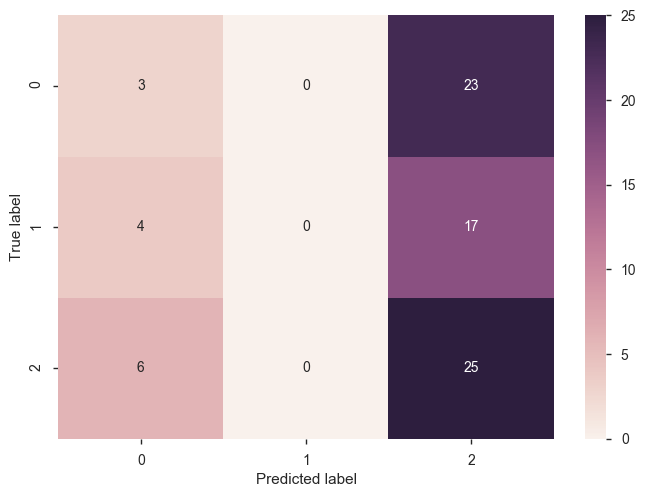

In [67]:
model = RandomForestClassifier(
    max_depth=clf.best_params_['max_depth'],
    min_samples_leaf=clf.best_params_['min_samples_leaf'],
    min_samples_split=clf.best_params_['min_samples_split'],
    n_estimators=clf.best_params_['n_estimators'],
    random_state=777)

model.fit(X_train, y_train)

y_pred = model.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

recall = cm[2][2]/sum(cm[2])
print('Recall: {}'.format(recall))
model_results['random_forest']['recall'] = recall

precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
print('Precision: {}'.format(precision))
model_results['random_forest']['precision'] = precision

accuracy = accuracy_score(y_pred, y_valid)
print('Accuracy: {}'.format(accuracy))
model_results['random_forest']['accuracy'] = accuracy

print('Feature importance based on entropy:')
d = dict(zip(list(X_train), model.feature_importances_))
fe_entropy = sorted(d.items(), key=lambda x: x[1], reverse=True)
model_results['random_forest']['fe_entropy'] = fe_entropy

print('Feature ranking with recursive feature elimination:')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
d = dict(zip(X.columns, selector.ranking_))
fe_rfe = sorted(d.items(), key=lambda x: x[1])
model_results['random_forest']['fe_rfe'] = fe_rfe

### LIME using Random Forests

In [68]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train, 
    feature_names=list(X_train),
    discretize_continuous=False
    )
i = np.random.randint(0, X_valid.shape[0])
exp = explainer.explain_instance(X_valid.iloc[i], model.predict_proba)
exp.show_in_notebook(show_table=True, show_all=False)

# Extra Trees

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=777,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [120, 300, 500, 800, 1200], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

{'min_samples_leaf': 5, 'min_samples_split': 100, 'n_estimators': 500}

Recall: 0.8064516129032258
Precision: 0.390625
Accuracy: 0.38461538461538464


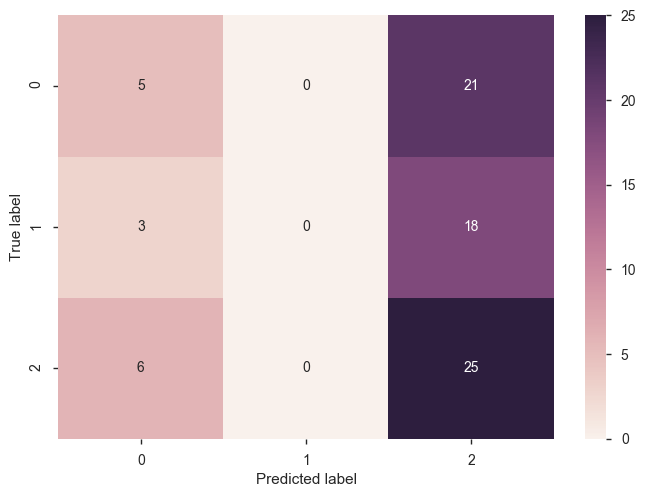

In [69]:
estimator = ExtraTreesClassifier(random_state=777)
param_grid = {
    'n_estimators': [120, 300, 500, 800, 1200],
    'min_samples_split': [2, 5, 10, 15, 100],
    'min_samples_leaf': [2, 5, 10]
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

y_pred = clf.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Precision: {}'.format(cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=5,
           min_samples_split=100, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=777,
           verbose=0, warm_start=False)

Recall: 0.8064516129032258
Precision: 0.390625
Accuracy: 0.38461538461538464
Feature importance based on entropy:
Feature ranking with recursive feature elimination:


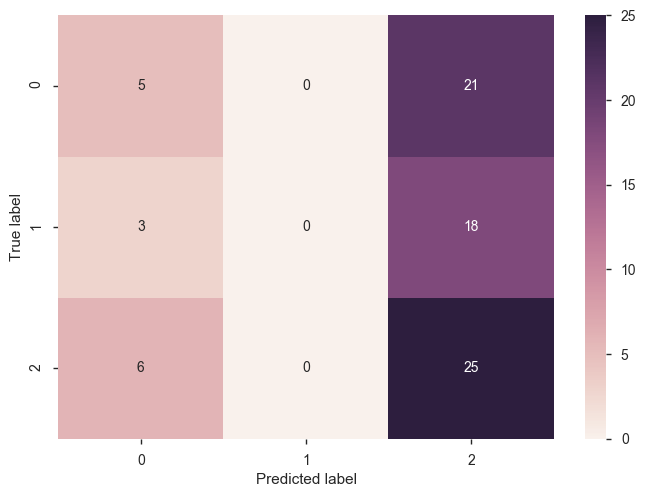

In [70]:
model = ExtraTreesClassifier(
    min_samples_leaf=clf.best_params_['min_samples_leaf'],
    min_samples_split=clf.best_params_['min_samples_split'],
    n_estimators=clf.best_params_['n_estimators'],
    random_state=777)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

recall = cm[2][2]/sum(cm[2])
print('Recall: {}'.format(recall))
model_results['extra_trees']['recall'] = recall

precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
print('Precision: {}'.format(precision))
model_results['extra_trees']['precision'] = precision

accuracy = accuracy_score(y_pred, y_valid)
print('Accuracy: {}'.format(accuracy))
model_results['extra_trees']['accuracy'] = accuracy

print('Feature importance based on entropy:')
d = dict(zip(list(X_train), model.feature_importances_))
fe_entropy = sorted(d.items(), key=lambda x: x[1], reverse=True)
model_results['extra_trees']['fe_entropy'] = fe_entropy

print('Feature ranking with recursive feature elimination:')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
d = dict(zip(X.columns, selector.ranking_))
fe_rfe = sorted(d.items(), key=lambda x: x[1])
model_results['extra_trees']['fe_rfe'] = fe_rfe

### LIME using Extra Trees

In [71]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train, 
    feature_names=list(X_train),
    discretize_continuous=False
    )
i = np.random.randint(0, X_valid.shape[0])
exp = explainer.explain_instance(X_valid.iloc[i], model.predict_proba)
exp.show_in_notebook(show_table=True, show_all=False)

### Garbage collection

In [72]:
del DecisionTreeClassifier, ExtraTreesClassifier, RandomForestClassifier, RandomizedSearchCV, RFE, SVG, Source, StratifiedKFold
del X, y, X_cluster, X_target, X_train, X_valid, accuracy, accuracy_score, categories, clf, cluster_colors, clusterer, cm
del confusion_matrix, convert_score, cuts, d, d_train, d_valid, df_categorical, df_continuous, df_discrete, df_numeric, dtc
del dtypes, estimator, eval_size, export_graphviz, f1_score, fe_entropy, fe_rfe, feature, g, graph, hdbscan
del i, kf, lgb, make_correlation_graphic, margin1, margin2, model, pair_vars, pandas_profiling, param_grid
del precision, precision_score, recall, recall_score, row, selector, target_class, train_ix, valid_ix, y_cluster, y_pred
del y_pred_trunc, y_train, y_valid
collect()

314

# Results

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


entropy  rfe  N_entropy     N_rfe     score
D__ASESOR COMERCIAL SENIOR       0.089264   30   0.486378  0.209305  0.695683
D__ASESOR COMERCIAL JUNIOR 2     0.047174   37   0.257041  0.258142  0.515184
pregunta_29                      0.050404   21   0.274641  0.146513  0.421154
D__Otros                         0.030735   33   0.167466  0.230235  0.397701
pregunta_13                      0.026451   27   0.144127  0.188374  0.332501
D__ASESOR COMERCIAL JUNIOR 1     0.013671   36   0.074489  0.251166  0.325655
pregunta_30                      0.036649   18   0.199689  0.125583  0.325272
D__ASESOR COMERCIAL FUNCIONARIO  0.010083   38   0.054939  0.265119  0.320058
D__Femenino                      0.011976   35   0.065255  0.244189  0.309443
pregunta_5                       0.054339    1   0.296076  0.006977  0.303053
D__Casado                        0.015825   31   0.086226  0.216281  0.302508
pregunta_10                      0.023430   25   0.127665  0.174420  0.302086
D__Soltero                       0.009560   34   0.052092  0.237212  0.289304
pregunta_16                      0.026179   20   0.142644  0.139536  0.282180
ingresoef                        0.015467   28   0.084275  0.195351  0.279626
cluster                          0.001307   39   0.007121  0.272096  0.279217
D__ASESOR COMERCIAL MASTER       0.009029   32   0.049194  0.223258  0.272452
D__Masculino                     0.012498   29   0.068096  0.202328  0.270424
pregunta_2                       0.037065    9   0.201956  0.062791  0.264748
pregunta_12                      0.014982   26   0.081635  0.181397  0.263033
pregunta_28                      0.017525   24   0.095487  0.167444  0.262931
pregunta_3                       0.016624   22   0.090581  0.153490  0.244071
pregunta_27                      0.043369    1   0.236307  0.006977  0.243283
pregunta_9                       0.015187   23   0.082750  0.160467  0.243217
pregunta_23                      0.042807    1   0.233246  0.006977  0.240223
pregunta_7                       0.022047   17   0.120127  0.118606  0.238733
pregunta_11                      0.019637   16   0.106999  0.111629  0.218628
pregunta_15                      0.020307   15   0.110650  0.104652  0.215302
pregunta_21                      0.021546   13   0.117399  0.090699  0.208098
Edad                             0.013645   19   0.074349  0.132560  0.206909
pregunta_22                      0.028172    7   0.153500  0.048838  0.202337
pregunta_18                      0.025067    8   0.136582  0.055815  0.192397
pregunta_20                      0.016220   14   0.088380  0.097675  0.186055
pregunta_8                       0.018485   11   0.100722  0.076745  0.177467
pregunta_14                      0.025754    2   0.140328  0.013954  0.154281
pregunta_24                      0.012409   12   0.067615  0.083722  0.151337
pregunta_6                       0.014496   10   0.078987  0.069768  0.148755
pregunta_4                       0.016287    6   0.088746  0.041861  0.130606
pregunta_26                      0.020060    1   0.109299  0.006977  0.116276
pregunta_25                      0.015063    4   0.082074  0.027907  0.109981
pregunta_1                       0.012513    5   0.068181  0.034884  0.103065
pregunta_17                      0.013462    3   0.073350  0.020930  0.094280
pregunta_19                      0.013227    1   0.072068  0.006977  0.079045

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text xticklabel objects>)

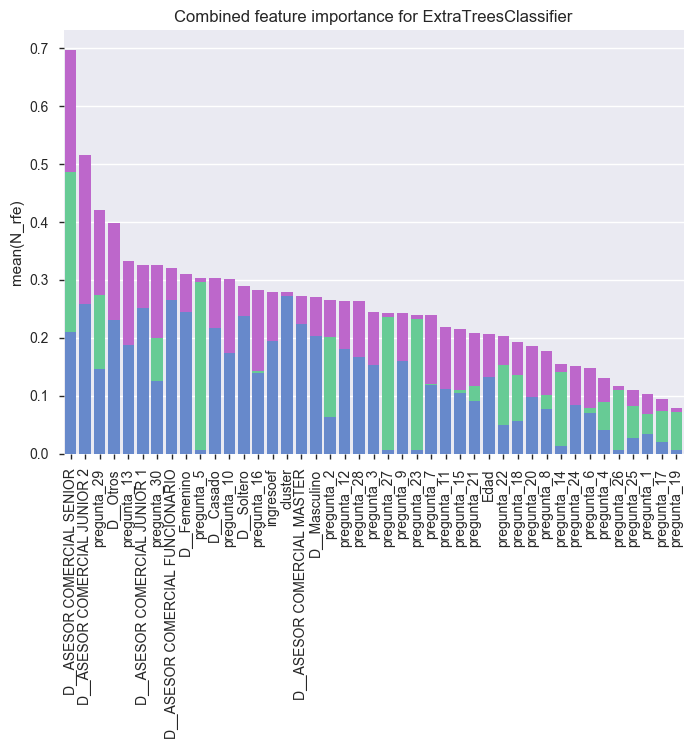

In [73]:
df1 = pd.DataFrame(model_results['extra_trees']['fe_entropy']).set_index(0)
df2 = pd.DataFrame(model_results['extra_trees']['fe_rfe']).set_index(0)
results_extra_trees = pd.concat([df1, df2], axis=1)

results_extra_trees.columns = ['entropy', 'rfe']
results_extra_trees['N_entropy'] = normalize(results_extra_trees['entropy'])[0]
results_extra_trees['N_rfe'] = normalize(results_extra_trees['rfe'])[0]

results_extra_trees['score'] = results_extra_trees['N_entropy'] + results_extra_trees['N_rfe']

results_extra_trees = results_extra_trees.sort_values('score', ascending=False)

results_extra_trees

plt.title('Combined feature importance for ExtraTreesClassifier')
sns.barplot(x=results_extra_trees.index, y=results_extra_trees['score'], color=sns.color_palette("hls", 5)[4])
sns.barplot(x=results_extra_trees.index, y=results_extra_trees['N_entropy'], color=sns.color_palette("hls", 5)[2])
sns.barplot(x=results_extra_trees.index, y=results_extra_trees['N_rfe'], color=sns.color_palette("hls", 5)[3])
plt.xticks(rotation=90)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


entropy  rfe  N_entropy     N_rfe     score
pregunta_8                       0.034864   25   0.193714  0.174420  0.368135
pregunta_13                      0.038429   22   0.213522  0.153490  0.367012
pregunta_6                       0.031516   24   0.175116  0.167444  0.342559
pregunta_4                       0.026164   26   0.145375  0.181397  0.326772
pregunta_23                      0.043593   11   0.242215  0.076745  0.318960
pregunta_30                      0.047852    5   0.265881  0.034884  0.300765
pregunta_17                      0.027458   21   0.152564  0.146513  0.299078
pregunta_3                       0.027446   19   0.152501  0.132560  0.285060
D__Masculino                     0.002113   39   0.011740  0.272096  0.283836
Edad                             0.016468   27   0.091499  0.188374  0.279874
pregunta_1                       0.021394   23   0.118870  0.160467  0.279337
pregunta_28                      0.024892   20   0.138307  0.139536  0.277843
pregunta_10                      0.032303   13   0.179488  0.090699  0.270187
D__ASESOR COMERCIAL JUNIOR 1     0.001566   37   0.008700  0.258142  0.266842
cluster                          0.000034   38   0.000191  0.265119  0.265310
pregunta_16                      0.027631   16   0.153529  0.111629  0.265158
D__Casado                        0.002507   36   0.013932  0.251166  0.265097
pregunta_2                       0.037460    8   0.208140  0.055815  0.263955
pregunta_9                       0.028176   15   0.156558  0.104652  0.261210
pregunta_12                      0.023573   18   0.130981  0.125583  0.256564
pregunta_29                      0.044827    1   0.249076  0.006977  0.256052
pregunta_18                      0.033142   10   0.184151  0.069768  0.253919
pregunta_5                       0.043990    1   0.244426  0.006977  0.251403
pregunta_25                      0.023791   17   0.132190  0.118606  0.250796
pregunta_14                      0.043256    1   0.240344  0.006977  0.247321
D__ASESOR COMERCIAL JUNIOR 2     0.005581   31   0.031010  0.216281  0.247292
D__Otros                         0.001798   34   0.009988  0.237212  0.247200
D__ASESOR COMERCIAL FUNCIONARIO  0.000449   35   0.002493  0.244189  0.246682
D__ASESOR COMERCIAL SENIOR       0.007857   28   0.043656  0.195351  0.239007
pregunta_24                      0.025425   14   0.141270  0.097675  0.238945
D__ASESOR COMERCIAL MASTER       0.001053   33   0.005848  0.230235  0.236083
pregunta_20                      0.026827   12   0.149059  0.083722  0.232780
ingresoef                        0.001451   32   0.008063  0.223258  0.231322
pregunta_27                      0.039989    1   0.222194  0.006977  0.229171
pregunta_22                      0.037354    3   0.207554  0.020930  0.228485
D__Soltero                       0.002333   30   0.012961  0.209305  0.222266
pregunta_11                      0.028650    9   0.159191  0.062791  0.221982
D__Femenino                      0.002334   29   0.012968  0.202328  0.215295
pregunta_21                      0.029425    4   0.163494  0.027907  0.191401
pregunta_19                      0.025469    7   0.141514  0.048838  0.190352
pregunta_7                       0.024837    6   0.138002  0.041861  0.179863
pregunta_26                      0.028143    2   0.156372  0.013954  0.170325
pregunta_15                      0.026582    1   0.147697  0.006977  0.154674

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text xticklabel objects>)

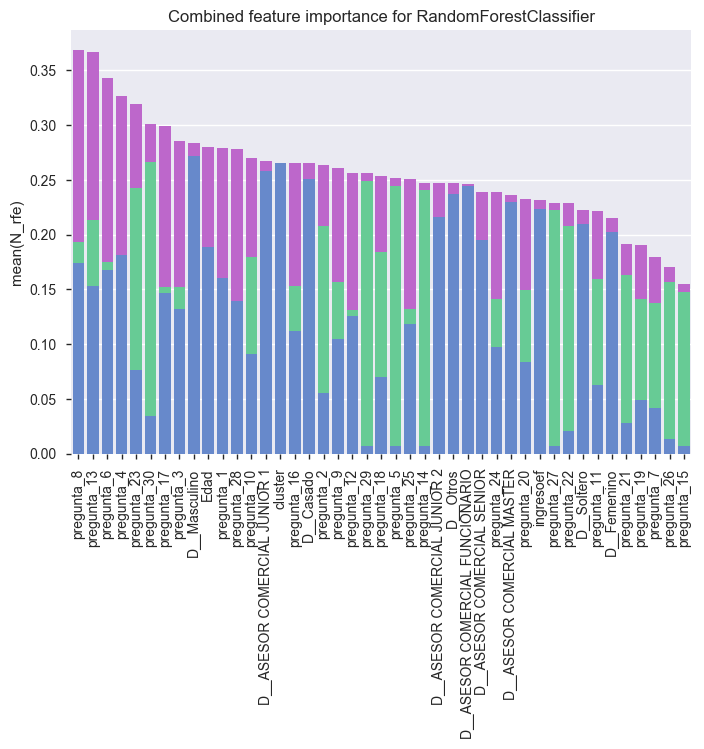

In [74]:
df1 = pd.DataFrame(model_results['random_forest']['fe_entropy']).set_index(0)
df2 = pd.DataFrame(model_results['random_forest']['fe_rfe']).set_index(0)
results_random_forest = pd.concat([df1, df2], axis=1)

results_random_forest.columns = ['entropy', 'rfe']
results_random_forest['N_entropy'] = normalize(results_random_forest['entropy'])[0]
results_random_forest['N_rfe'] = normalize(results_random_forest['rfe'])[0]

results_random_forest['score'] = results_random_forest['N_entropy'] + results_random_forest['N_rfe']

results_random_forest = results_random_forest.sort_values('score', ascending=False)

results_random_forest

plt.title('Combined feature importance for RandomForestClassifier')
sns.barplot(x=results_random_forest.index, y=results_random_forest['score'], color=sns.color_palette("hls", 5)[4])
sns.barplot(x=results_random_forest.index, y=results_random_forest['N_entropy'], color=sns.color_palette("hls", 5)[2])
sns.barplot(x=results_random_forest.index, y=results_random_forest['N_rfe'], color=sns.color_palette("hls", 5)[3])
plt.xticks(rotation=90)

0  pregunta_29  pregunta_5  pregunta_23  pregunta_27  pregunta_14  \
1          346         276          274          270          269   

0  pregunta_11  pregunta_22  pregunta_13  pregunta_21  pregunta_2   ...     \
1          267          267          257          250         248   ...      

0  D__Casado  D__Femenino  ingresoef  D__ASESOR_COMERCIAL_JUNIOR_1  \
1          6            3          2                             2   

0  D__ASESOR_COMERCIAL_MASTER  D__Otros  D__Soltero  \
1                           1         1           1   

0  D__ASESOR_COMERCIAL_FUNCIONARIO  D__Masculino  cluster  
1                                0             0        0  

[1 rows x 43 columns]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


entropy  rfe  N_entropy     N_rfe     score
pregunta_10                          220   26   0.172713  0.181397  0.354110
pregunta_13                          257   21   0.201760  0.146513  0.348273
pregunta_1                           198   27   0.155441  0.188374  0.343816
pregunta_14                          269   16   0.211181  0.111629  0.322810
pregunta_25                          197   23   0.154656  0.160467  0.315123
pregunta_21                          250   17   0.196264  0.118606  0.314870
pregunta_28                          180   24   0.141310  0.167444  0.308754
pregunta_19                          236   15   0.185274  0.104652  0.289926
pregunta_11                          267   11   0.209610  0.076745  0.286355
pregunta_17                          199   18   0.156226  0.125583  0.281809
pregunta_22                          267   10   0.209610  0.069768  0.279379
pregunta_29                          346    1   0.271630  0.006977  0.278607
pregunta_18                          185   19   0.145236  0.132560  0.277795
pregunta_30                          227   14   0.178208  0.097675  0.275884
pregunta_3                           155   22   0.121684  0.153490  0.275174
cluster                                0   39   0.000000  0.272096  0.272096
ingresoef                              2   38   0.001570  0.265119  0.266689
pregunta_6                           160   20   0.125609  0.139536  0.265146
D__Femenino                            3   37   0.002355  0.258142  0.260498
Edad                                 109   25   0.085571  0.174420  0.259992
pregunta_9                           222   12   0.174283  0.083722  0.258005
D__ASESOR COMERCIAL MASTER             1   36   0.000785  0.251166  0.251951
pregunta_2                           248    8   0.194694  0.055815  0.250509
D__ASESOR COMERCIAL JUNIOR 1           2   35   0.001570  0.244189  0.245759
D__ASESOR COMERCIAL SENIOR            55   28   0.043178  0.195351  0.238529
D__ASESOR COMERCIAL FUNCIONARIO        0   34   0.000000  0.237212  0.237212
pregunta_12                          180   13   0.141310  0.090699  0.232009
D__Otros                               1   33   0.000785  0.230235  0.231020
pregunta_26                          214    9   0.168002  0.062791  0.230794
pregunta_5                           276    1   0.216676  0.006977  0.223653
D__Masculino                           0   32   0.000000  0.223258  0.223258
pregunta_23                          274    1   0.215106  0.006977  0.222083
pregunta_20                          218    7   0.171143  0.048838  0.219980
pregunta_27                          270    1   0.211966  0.006977  0.218942
pregunta_4                           233    5   0.182918  0.034884  0.217803
D__ASESOR COMERCIAL JUNIOR 2          10   30   0.007851  0.209305  0.217155
D__Soltero                             1   31   0.000785  0.216281  0.217066
pregunta_8                           232    4   0.182133  0.027907  0.210041
pregunta_15                          214    6   0.168002  0.041861  0.209863
D__Casado                              6   29   0.004710  0.202328  0.207038
pregunta_7                           234    1   0.183704  0.006977  0.190680
pregunta_16                          216    3   0.169572  0.020930  0.190503
pregunta_24                          197    2   0.154656  0.013954  0.168610

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text xticklabel objects>)

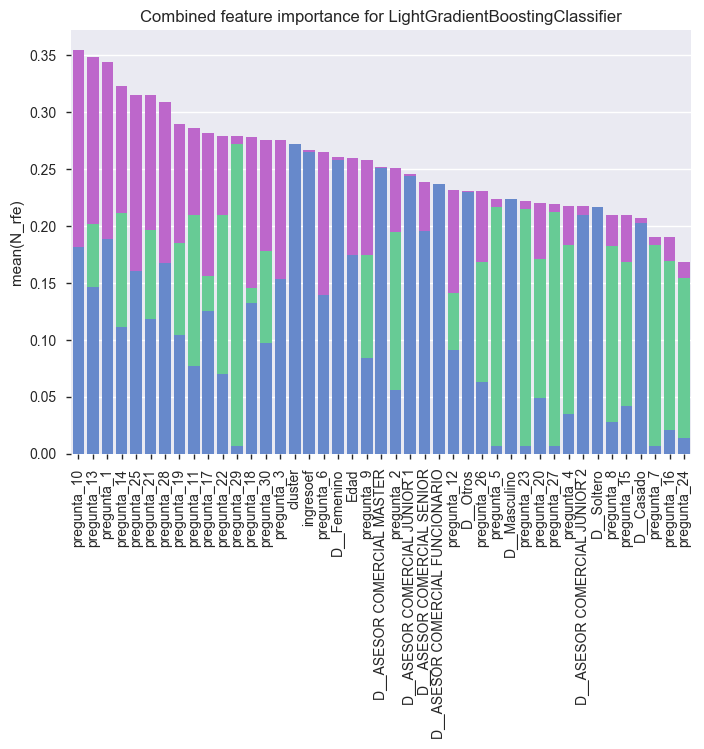

In [75]:
df1 = pd.DataFrame(model_results['lightgbm']['fe_entropy']).set_index(0)
df2 = pd.DataFrame(model_results['lightgbm']['fe_rfe']).set_index(0)

df1 = df1.T
df1

for feature in [col for col in df1.columns if col.startswith('D_')]:
    df1 = df1.rename(columns={
        feature: feature.replace('_', ' ').replace('D  ', 'D__')
    })

df1 = df1.T
    
results_lightgbm = pd.concat([df1, df2], axis=1)

results_lightgbm.columns = ['entropy', 'rfe']
results_lightgbm['N_entropy'] = normalize(results_lightgbm['entropy'])[0]
results_lightgbm['N_rfe'] = normalize(results_lightgbm['rfe'])[0]

results_lightgbm['score'] = results_lightgbm['N_entropy'] + results_lightgbm['N_rfe']

results_lightgbm = results_lightgbm.sort_values('score', ascending=False)

results_lightgbm

plt.title('Combined feature importance for LightGradientBoostingClassifier')
sns.barplot(x=results_lightgbm.index, y=results_lightgbm['score'], color=sns.color_palette("hls", 5)[4])
sns.barplot(x=results_lightgbm.index, y=results_lightgbm['N_entropy'], color=sns.color_palette("hls", 5)[2])
sns.barplot(x=results_lightgbm.index, y=results_lightgbm['N_rfe'], color=sns.color_palette("hls", 5)[3])
plt.xticks(rotation=90)

extra_trees  random_forest  lightgbm  \
D__ASESOR COMERCIAL SENIOR          0.695683       0.239007  0.238529   
pregunta_13                         0.332501       0.367012  0.348273   
D__ASESOR COMERCIAL JUNIOR 2        0.515184       0.247292  0.217155   
pregunta_29                         0.421154       0.256052  0.278607   
pregunta_10                         0.302086       0.270187  0.354110   
pregunta_30                         0.325272       0.300765  0.275884   
D__Otros                            0.397701       0.247200  0.231020   
pregunta_28                         0.262931       0.277843  0.308754   
D__ASESOR COMERCIAL JUNIOR 1        0.325655       0.266842  0.245759   
cluster                             0.279217       0.265310  0.272096   
pregunta_3                          0.244071       0.285060  0.275174   
D__ASESOR COMERCIAL FUNCIONARIO     0.320058       0.246682  0.237212   
D__Femenino                         0.309443       0.215295  0.260498   
pregunta_23                         0.240223       0.318960  0.222083   
pregunta_2                          0.264748       0.263955  0.250509   
pregunta_5                          0.303053       0.251403  0.223653   
ingresoef                           0.279626       0.231322  0.266689   
D__Masculino                        0.270424       0.283836  0.223258   
D__Casado                           0.302508       0.265097  0.207038   
pregunta_9                          0.243217       0.261210  0.258005   
D__ASESOR COMERCIAL MASTER          0.272452       0.236083  0.251951   
pregunta_6                          0.148755       0.342559  0.265146   
pregunta_8                          0.177467       0.368135  0.210041   
pregunta_12                         0.263033       0.256564  0.232009   
Edad                                0.206909       0.279874  0.259992   
pregunta_16                         0.282180       0.265158  0.190503   
D__Soltero                          0.289304       0.222266  0.217066   
pregunta_11                         0.218628       0.221982  0.286355   
pregunta_1                          0.103065       0.279337  0.343816   
pregunta_14                         0.154281       0.247321  0.322810   
pregunta_18                         0.192397       0.253919  0.277795   
pregunta_21                         0.208098       0.191401  0.314870   
pregunta_22                         0.202337       0.228485  0.279379   
pregunta_27                         0.243283       0.229171  0.218942   
pregunta_25                         0.109981       0.250796  0.315123   
pregunta_4                          0.130606       0.326772  0.217803   
pregunta_17                         0.094280       0.299078  0.281809   
pregunta_20                         0.186055       0.232780  0.219980   
pregunta_7                          0.238733       0.179863  0.190680   
pregunta_15                         0.215302       0.154674  0.209863   
pregunta_19                         0.079045       0.190352  0.289926   
pregunta_24                         0.151337       0.238945  0.168610   
pregunta_26                         0.116276       0.170325  0.230794   

                                    score  
D__ASESOR COMERCIAL SENIOR       1.173219  
pregunta_13                      1.047786  
D__ASESOR COMERCIAL JUNIOR 2     0.979630  
pregunta_29                      0.955813  
pregunta_10                      0.926383  
pregunta_30                      0.901920  
D__Otros                         0.875921  
pregunta_28                      0.849528  
D__ASESOR COMERCIAL JUNIOR 1     0.838256  
cluster                          0.816623  
pregunta_3                       0.804306  
D__ASESOR COMERCIAL FUNCIONARIO  0.803952  
D__Femenino                      0.785236  
pregunta_23                      0.781266  
pregunta_2                       0.779211  
pregunta_5                       0.778109  
ingresoef                        0.777637  
D__Masculino                

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text xticklabel objects>)

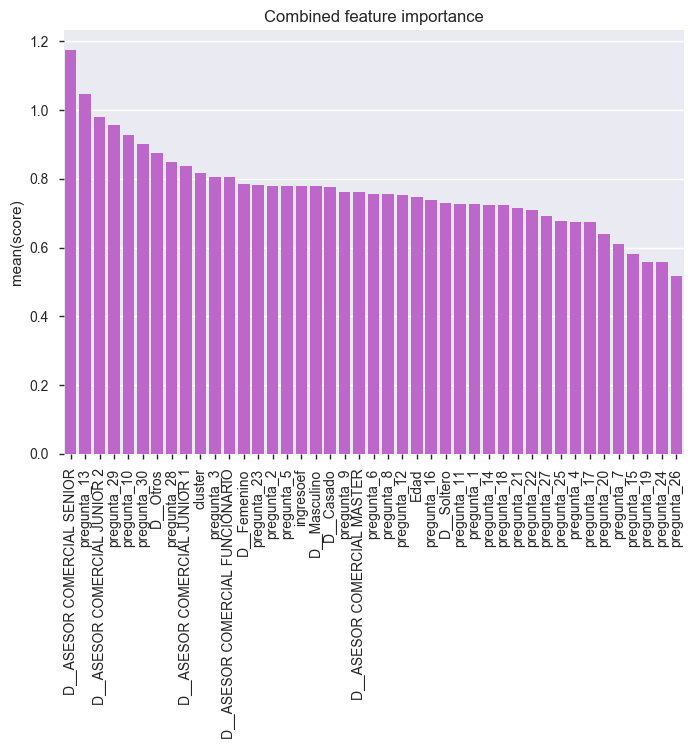

In [76]:
df_results = pd.concat([results_extra_trees['score'], results_random_forest['score'], results_lightgbm['score']], axis=1)
df_results.columns = ['extra_trees', 'random_forest', 'lightgbm']
df_results['score'] = df_results['extra_trees'] + df_results['random_forest'] + df_results['lightgbm']

df_results = df_results.sort_values('score', ascending=False)

df_results

plt.title('Combined feature importance')
sns.barplot(x=df_results.index, y=df_results['score'], color=sns.color_palette("hls", 5)[4])
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text xticklabel objects>)

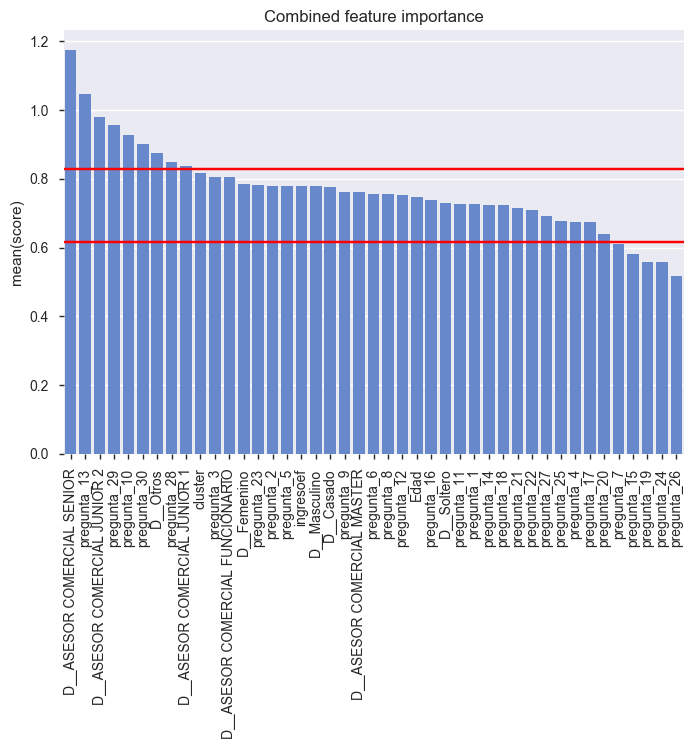

In [77]:
margin1 = 0.1
margin2 = 0.8

plt.title('Combined feature importance')
sns.barplot(x=df_results.index, y=df_results['score'], color=sns.color_palette("hls", 5)[3])
plt.xticks(rotation=90)
sns.plt.axhline(df_results['score'].quantile(margin1), color='r')
sns.plt.axhline(df_results['score'].quantile(margin2), color='r')

In [78]:
categories = ['bad', 'uncertain', 'good']
cuts = [
    min(df_results['score']), 
    df_results['score'].quantile(margin1), 
    df_results['score'].quantile(margin2), 
    max(df_results['score'])
]
df_results['score'] = pd.cut(df_results['score'], cuts, labels=categories, include_lowest=True)
df_results['score']

D__ASESOR COMERCIAL SENIOR              good
pregunta_13                             good
D__ASESOR COMERCIAL JUNIOR 2            good
pregunta_29                             good
pregunta_10                             good
pregunta_30                             good
D__Otros                                good
pregunta_28                             good
D__ASESOR COMERCIAL JUNIOR 1            good
cluster                            uncertain
pregunta_3                         uncertain
D__ASESOR COMERCIAL FUNCIONARIO    uncertain
D__Femenino                        uncertain
pregunta_23                        uncertain
pregunta_2                         uncertain
pregunta_5                         uncertain
ingresoef                          uncertain
D__Masculino                       uncertain
D__Casado                          uncertain
pregunta_9                         uncertain
D__ASESOR COMERCIAL MASTER         uncertain
pregunta_6                         uncertain
pregunta_8

In [79]:
df_results.to_csv('hk1_initial_pass_results.csv')

In [80]:
uncertain_features = list(df_results.loc[df_results['score'] == 'uncertain'].T.columns)

In [81]:
with open('hk1_uncertain_features.txt', 'wb') as fp:
    pickle.dump(uncertain_features, fp)

# Model benchmark

In [ ]:
s1 = pd.Series(model_results['lightgbm'], name='lightgbm')[['accuracy', 'precision', 'recall']]
s2 = pd.Series(model_results['random_forest'], name='random_forest')[['accuracy', 'precision', 'recall']]
s3 = pd.Series(model_results['extra_trees'], name='extra_trees')[['accuracy', 'precision', 'recall']]
dff = pd.concat([s1, s2, s3], axis=1).T
dff = dff.reset_index()
dff
plt.figure()
sns.pointplot(x="index", y="accuracy", data=dff.reset_index(), palette="Set2")
plt.figure()
sns.pointplot(x="index", y="recall", data=dff, palette="Set2")
plt.figure()
sns.pointplot(x="index", y="precision", data=dff, palette="Set2")